In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 30
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_glcm_Contrast_glcm_Correlation_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortR

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 558)
(772408, 8)
validation
(101248, 558)
(101248, 8)
test
(98888, 558)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 558)]             0         


 dense (Dense)               (None, 1024)              572416    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1262472 (4.82 MB)


Trainable params: 1262472 (4.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:47 - loss: 2.1203 - STD: 0.0683 - MAE: 0.2177

 4/78 [>.............................] - ETA: 1s - loss: 1.6189 - STD: 0.1191 - MAE: 0.1809  

 6/78 [=>............................] - ETA: 2s - loss: 1.5334 - STD: 0.1595 - MAE: 0.1628

 8/78 [==>...........................] - ETA: 2s - loss: 1.4997 - STD: 0.1829 - MAE: 0.1526

10/78 [==>...........................] - ETA: 2s - loss: 1.4789 - STD: 0.1942 - MAE: 0.1477

12/78 [===>..........................] - ETA: 2s - loss: 1.4587 - STD: 0.1977 - MAE: 0.1459

14/78 [====>.........................] - ETA: 2s - loss: 1.4389 - STD: 0.1968 - MAE: 0.1458

16/78 [=====>........................] - ETA: 2s - loss: 1.4267 - STD: 0.1942 - MAE: 0.1465

18/78 [=====>........................] - ETA: 2s - loss: 1.4175 - STD: 0.1917 - MAE: 0.1473

20/78 [======>.......................] - ETA: 2s - loss: 1.4085 - STD: 0.1901 - MAE: 0.1477

21/78 [=======>......................] - ETA: 2s - loss: 1.4051 - STD: 0.1897 - MAE: 0.1479

23/78 [=======>......................] - ETA: 2s - loss: 1.3984 - STD: 0.1896 - MAE: 0.1477

25/78 [========>.....................] - ETA: 2s - loss: 1.3938 - STD: 0.1903 - MAE: 0.1474

26/78 [=========>....................] - ETA: 3s - loss: 1.3930 - STD: 0.1907 - MAE: 0.1472

30/78 [==========>...................] - ETA: 2s - loss: 1.3833 - STD: 0.1922 - MAE: 0.1464

32/78 [===========>..................] - ETA: 2s - loss: 1.3797 - STD: 0.1924 - MAE: 0.1463

34/78 [============>.................] - ETA: 2s - loss: 1.3757 - STD: 0.1923 - MAE: 0.1463

36/78 [============>.................] - ETA: 2s - loss: 1.3725 - STD: 0.1920 - MAE: 0.1463

38/78 [=============>................] - ETA: 2s - loss: 1.3693 - STD: 0.1917 - MAE: 0.1464

40/78 [==============>...............] - ETA: 2s - loss: 1.3667 - STD: 0.1915 - MAE: 0.1464

42/78 [===============>..............] - ETA: 1s - loss: 1.3645 - STD: 0.1914 - MAE: 0.1464

44/78 [===============>..............] - ETA: 1s - loss: 1.3621 - STD: 0.1915 - MAE: 0.1463

46/78 [================>.............] - ETA: 1s - loss: 1.3602 - STD: 0.1916 - MAE: 0.1462

48/78 [=================>............] - ETA: 1s - loss: 1.3578 - STD: 0.1917 - MAE: 0.1461

50/78 [==================>...........] - ETA: 1s - loss: 1.3563 - STD: 0.1917 - MAE: 0.1461

52/78 [===================>..........] - ETA: 1s - loss: 1.3549 - STD: 0.1917 - MAE: 0.1461

54/78 [===================>..........] - ETA: 1s - loss: 1.3531 - STD: 0.1917 - MAE: 0.1460

56/78 [====================>.........] - ETA: 1s - loss: 1.3518 - STD: 0.1916 - MAE: 0.1460

58/78 [=====================>........] - ETA: 1s - loss: 1.3508 - STD: 0.1916 - MAE: 0.1460

60/78 [======================>.......] - ETA: 0s - loss: 1.3494 - STD: 0.1915 - MAE: 0.1460

62/78 [======================>.......] - ETA: 0s - loss: 1.3486 - STD: 0.1916 - MAE: 0.1460

64/78 [=======================>......] - ETA: 0s - loss: 1.3475 - STD: 0.1916 - MAE: 0.1460

66/78 [========================>.....] - ETA: 0s - loss: 1.3465 - STD: 0.1916 - MAE: 0.1460

68/78 [=========================>....] - ETA: 0s - loss: 1.3455 - STD: 0.1916 - MAE: 0.1459

70/78 [=========================>....] - ETA: 0s - loss: 1.3448 - STD: 0.1916 - MAE: 0.1459

72/78 [==========================>...] - ETA: 0s - loss: 1.3440 - STD: 0.1916 - MAE: 0.1459

74/78 [===========================>..] - ETA: 0s - loss: 1.3434 - STD: 0.1915 - MAE: 0.1459

76/78 [============================>.] - ETA: 0s - loss: 1.3427 - STD: 0.1915 - MAE: 0.1459

78/78 [==============================] - ETA: 0s - loss: 1.3423 - STD: 0.1915 - MAE: 0.1459

78/78 [==============================] - 6s 59ms/step - loss: 1.3423 - STD: 0.1915 - MAE: 0.1459 - val_loss: 1.2730 - val_STD: 0.1907 - val_MAE: 0.1453


Epoch 2/10000


 1/78 [..............................] - ETA: 5s - loss: 1.3330 - STD: 0.1908 - MAE: 0.1468

 3/78 [>.............................] - ETA: 3s - loss: 1.3233 - STD: 0.1902 - MAE: 0.1464

 5/78 [>.............................] - ETA: 3s - loss: 1.3201 - STD: 0.1899 - MAE: 0.1463

 7/78 [=>............................] - ETA: 2s - loss: 1.3169 - STD: 0.1900 - MAE: 0.1460

 9/78 [==>...........................] - ETA: 2s - loss: 1.3156 - STD: 0.1905 - MAE: 0.1458

11/78 [===>..........................] - ETA: 2s - loss: 1.3175 - STD: 0.1910 - MAE: 0.1457

13/78 [====>.........................] - ETA: 2s - loss: 1.3151 - STD: 0.1912 - MAE: 0.1454

15/78 [====>.........................] - ETA: 2s - loss: 1.3154 - STD: 0.1913 - MAE: 0.1454

17/78 [=====>........................] - ETA: 2s - loss: 1.3141 - STD: 0.1913 - MAE: 0.1454

19/78 [======>.......................] - ETA: 2s - loss: 1.3141 - STD: 0.1913 - MAE: 0.1453

21/78 [=======>......................] - ETA: 2s - loss: 1.3135 - STD: 0.1914 - MAE: 0.1453

23/78 [=======>......................] - ETA: 2s - loss: 1.3128 - STD: 0.1915 - MAE: 0.1452

25/78 [========>.....................] - ETA: 2s - loss: 1.3131 - STD: 0.1916 - MAE: 0.1452

27/78 [=========>....................] - ETA: 2s - loss: 1.3129 - STD: 0.1917 - MAE: 0.1451

29/78 [==========>...................] - ETA: 2s - loss: 1.3133 - STD: 0.1917 - MAE: 0.1452

31/78 [==========>...................] - ETA: 2s - loss: 1.3128 - STD: 0.1915 - MAE: 0.1452

33/78 [===========>..................] - ETA: 1s - loss: 1.3114 - STD: 0.1914 - MAE: 0.1452

35/78 [============>.................] - ETA: 1s - loss: 1.3110 - STD: 0.1914 - MAE: 0.1451

37/78 [=============>................] - ETA: 1s - loss: 1.3112 - STD: 0.1915 - MAE: 0.1451

39/78 [==============>...............] - ETA: 1s - loss: 1.3107 - STD: 0.1915 - MAE: 0.1451

41/78 [==============>...............] - ETA: 1s - loss: 1.3100 - STD: 0.1915 - MAE: 0.1451

43/78 [===============>..............] - ETA: 1s - loss: 1.3090 - STD: 0.1915 - MAE: 0.1450

45/78 [================>.............] - ETA: 1s - loss: 1.3080 - STD: 0.1915 - MAE: 0.1450

47/78 [=================>............] - ETA: 1s - loss: 1.3080 - STD: 0.1917 - MAE: 0.1449

49/78 [=================>............] - ETA: 1s - loss: 1.3073 - STD: 0.1916 - MAE: 0.1449

51/78 [==================>...........] - ETA: 1s - loss: 1.3060 - STD: 0.1915 - MAE: 0.1449

53/78 [===================>..........] - ETA: 1s - loss: 1.3057 - STD: 0.1916 - MAE: 0.1449

54/78 [===================>..........] - ETA: 1s - loss: 1.3053 - STD: 0.1916 - MAE: 0.1448

56/78 [====================>.........] - ETA: 0s - loss: 1.3042 - STD: 0.1916 - MAE: 0.1448

58/78 [=====================>........] - ETA: 0s - loss: 1.3032 - STD: 0.1916 - MAE: 0.1448

60/78 [======================>.......] - ETA: 0s - loss: 1.3023 - STD: 0.1917 - MAE: 0.1447

62/78 [======================>.......] - ETA: 0s - loss: 1.3009 - STD: 0.1917 - MAE: 0.1446

64/78 [=======================>......] - ETA: 0s - loss: 1.2995 - STD: 0.1918 - MAE: 0.1446

66/78 [========================>.....] - ETA: 0s - loss: 1.2978 - STD: 0.1919 - MAE: 0.1444

68/78 [=========================>....] - ETA: 0s - loss: 1.2956 - STD: 0.1921 - MAE: 0.1443

70/78 [=========================>....] - ETA: 0s - loss: 1.2940 - STD: 0.1922 - MAE: 0.1442

72/78 [==========================>...] - ETA: 0s - loss: 1.2919 - STD: 0.1923 - MAE: 0.1441

74/78 [===========================>..] - ETA: 0s - loss: 1.2899 - STD: 0.1924 - MAE: 0.1440

76/78 [============================>.] - ETA: 0s - loss: 1.2881 - STD: 0.1925 - MAE: 0.1439

78/78 [==============================] - ETA: 0s - loss: 1.2861 - STD: 0.1927 - MAE: 0.1437

78/78 [==============================] - 4s 47ms/step - loss: 1.2861 - STD: 0.1927 - MAE: 0.1437 - val_loss: 1.1559 - val_STD: 0.1980 - val_MAE: 0.1376


Epoch 3/10000


 1/78 [..............................] - ETA: 6s - loss: 1.2066 - STD: 0.1982 - MAE: 0.1387

 3/78 [>.............................] - ETA: 3s - loss: 1.2020 - STD: 0.1984 - MAE: 0.1386

 5/78 [>.............................] - ETA: 3s - loss: 1.2030 - STD: 0.1983 - MAE: 0.1387

 7/78 [=>............................] - ETA: 3s - loss: 1.2005 - STD: 0.1989 - MAE: 0.1384

 9/78 [==>...........................] - ETA: 3s - loss: 1.2000 - STD: 0.1987 - MAE: 0.1385

11/78 [===>..........................] - ETA: 3s - loss: 1.1992 - STD: 0.1990 - MAE: 0.1384

13/78 [====>.........................] - ETA: 3s - loss: 1.1981 - STD: 0.1985 - MAE: 0.1386

15/78 [====>.........................] - ETA: 2s - loss: 1.1936 - STD: 0.1988 - MAE: 0.1382

17/78 [=====>........................] - ETA: 2s - loss: 1.1914 - STD: 0.1991 - MAE: 0.1381

19/78 [======>.......................] - ETA: 2s - loss: 1.1894 - STD: 0.1998 - MAE: 0.1377

21/78 [=======>......................] - ETA: 2s - loss: 1.1868 - STD: 0.1994 - MAE: 0.1377

23/78 [=======>......................] - ETA: 2s - loss: 1.1844 - STD: 0.1997 - MAE: 0.1375

25/78 [========>.....................] - ETA: 2s - loss: 1.1817 - STD: 0.1999 - MAE: 0.1373

27/78 [=========>....................] - ETA: 2s - loss: 1.1819 - STD: 0.2001 - MAE: 0.1373

29/78 [==========>...................] - ETA: 2s - loss: 1.1808 - STD: 0.1998 - MAE: 0.1375

31/78 [==========>...................] - ETA: 2s - loss: 1.1790 - STD: 0.1997 - MAE: 0.1374

33/78 [===========>..................] - ETA: 2s - loss: 1.1774 - STD: 0.2002 - MAE: 0.1372

35/78 [============>.................] - ETA: 1s - loss: 1.1757 - STD: 0.2003 - MAE: 0.1371

37/78 [=============>................] - ETA: 1s - loss: 1.1740 - STD: 0.2002 - MAE: 0.1371

39/78 [==============>...............] - ETA: 1s - loss: 1.1722 - STD: 0.2004 - MAE: 0.1369

41/78 [==============>...............] - ETA: 1s - loss: 1.1698 - STD: 0.2006 - MAE: 0.1368

43/78 [===============>..............] - ETA: 1s - loss: 1.1684 - STD: 0.2006 - MAE: 0.1367

45/78 [================>.............] - ETA: 1s - loss: 1.1663 - STD: 0.2007 - MAE: 0.1367

47/78 [=================>............] - ETA: 1s - loss: 1.1643 - STD: 0.2008 - MAE: 0.1365

49/78 [=================>............] - ETA: 1s - loss: 1.1621 - STD: 0.2009 - MAE: 0.1365

51/78 [==================>...........] - ETA: 1s - loss: 1.1596 - STD: 0.2009 - MAE: 0.1364

53/78 [===================>..........] - ETA: 1s - loss: 1.1571 - STD: 0.2012 - MAE: 0.1362

55/78 [====================>.........] - ETA: 1s - loss: 1.1544 - STD: 0.2012 - MAE: 0.1361

57/78 [====================>.........] - ETA: 0s - loss: 1.1516 - STD: 0.2016 - MAE: 0.1359

59/78 [=====================>........] - ETA: 0s - loss: 1.1488 - STD: 0.2016 - MAE: 0.1357

61/78 [======================>.......] - ETA: 0s - loss: 1.1460 - STD: 0.2020 - MAE: 0.1355

63/78 [=======================>......] - ETA: 0s - loss: 1.1436 - STD: 0.2021 - MAE: 0.1354

65/78 [========================>.....] - ETA: 0s - loss: 1.1412 - STD: 0.2023 - MAE: 0.1352

67/78 [========================>.....] - ETA: 0s - loss: 1.1389 - STD: 0.2025 - MAE: 0.1350

69/78 [=========================>....] - ETA: 0s - loss: 1.1365 - STD: 0.2027 - MAE: 0.1349

71/78 [==========================>...] - ETA: 0s - loss: 1.1341 - STD: 0.2029 - MAE: 0.1347

73/78 [===========================>..] - ETA: 0s - loss: 1.1316 - STD: 0.2031 - MAE: 0.1345

75/78 [===========================>..] - ETA: 0s - loss: 1.1295 - STD: 0.2033 - MAE: 0.1344

77/78 [============================>.] - ETA: 0s - loss: 1.1268 - STD: 0.2035 - MAE: 0.1342

78/78 [==============================] - 4s 48ms/step - loss: 1.1257 - STD: 0.2036 - MAE: 0.1341 - val_loss: 1.0237 - val_STD: 0.2093 - val_MAE: 0.1280


Epoch 4/10000


 1/78 [..............................] - ETA: 5s - loss: 1.0306 - STD: 0.2106 - MAE: 0.1278

 2/78 [..............................] - ETA: 3s - loss: 1.0307 - STD: 0.2107 - MAE: 0.1278

 4/78 [>.............................] - ETA: 3s - loss: 1.0339 - STD: 0.2113 - MAE: 0.1278

 6/78 [=>............................] - ETA: 3s - loss: 1.0306 - STD: 0.2114 - MAE: 0.1276

 7/78 [=>............................] - ETA: 3s - loss: 1.0292 - STD: 0.2121 - MAE: 0.1272

 9/78 [==>...........................] - ETA: 3s - loss: 1.0303 - STD: 0.2114 - MAE: 0.1276

11/78 [===>..........................] - ETA: 3s - loss: 1.0254 - STD: 0.2120 - MAE: 0.1271

13/78 [====>.........................] - ETA: 3s - loss: 1.0250 - STD: 0.2121 - MAE: 0.1271

15/78 [====>.........................] - ETA: 2s - loss: 1.0241 - STD: 0.2122 - MAE: 0.1270

17/78 [=====>........................] - ETA: 2s - loss: 1.0246 - STD: 0.2120 - MAE: 0.1271

18/78 [=====>........................] - ETA: 2s - loss: 1.0239 - STD: 0.2122 - MAE: 0.1270

20/78 [======>.......................] - ETA: 2s - loss: 1.0219 - STD: 0.2124 - MAE: 0.1268

22/78 [=======>......................] - ETA: 2s - loss: 1.0205 - STD: 0.2123 - MAE: 0.1268

24/78 [========>.....................] - ETA: 2s - loss: 1.0187 - STD: 0.2125 - MAE: 0.1266

26/78 [=========>....................] - ETA: 2s - loss: 1.0169 - STD: 0.2128 - MAE: 0.1264

28/78 [=========>....................] - ETA: 2s - loss: 1.0157 - STD: 0.2126 - MAE: 0.1265

30/78 [==========>...................] - ETA: 2s - loss: 1.0126 - STD: 0.2129 - MAE: 0.1262

32/78 [===========>..................] - ETA: 2s - loss: 1.0099 - STD: 0.2130 - MAE: 0.1261

34/78 [============>.................] - ETA: 1s - loss: 1.0089 - STD: 0.2131 - MAE: 0.1260

36/78 [============>.................] - ETA: 1s - loss: 1.0065 - STD: 0.2136 - MAE: 0.1256

38/78 [=============>................] - ETA: 1s - loss: 1.0049 - STD: 0.2134 - MAE: 0.1257

40/78 [==============>...............] - ETA: 1s - loss: 1.0033 - STD: 0.2139 - MAE: 0.1254

42/78 [===============>..............] - ETA: 1s - loss: 1.0019 - STD: 0.2139 - MAE: 0.1253

44/78 [===============>..............] - ETA: 1s - loss: 1.0001 - STD: 0.2140 - MAE: 0.1252

46/78 [================>.............] - ETA: 1s - loss: 0.9983 - STD: 0.2144 - MAE: 0.1250

48/78 [=================>............] - ETA: 1s - loss: 0.9970 - STD: 0.2142 - MAE: 0.1250

50/78 [==================>...........] - ETA: 1s - loss: 0.9954 - STD: 0.2146 - MAE: 0.1247

52/78 [===================>..........] - ETA: 1s - loss: 0.9935 - STD: 0.2146 - MAE: 0.1246

54/78 [===================>..........] - ETA: 1s - loss: 0.9912 - STD: 0.2150 - MAE: 0.1244

56/78 [====================>.........] - ETA: 0s - loss: 0.9895 - STD: 0.2150 - MAE: 0.1243

58/78 [=====================>........] - ETA: 0s - loss: 0.9880 - STD: 0.2154 - MAE: 0.1240

60/78 [======================>.......] - ETA: 0s - loss: 0.9864 - STD: 0.2154 - MAE: 0.1240

62/78 [======================>.......] - ETA: 0s - loss: 0.9846 - STD: 0.2157 - MAE: 0.1238

64/78 [=======================>......] - ETA: 0s - loss: 0.9833 - STD: 0.2157 - MAE: 0.1237

66/78 [========================>.....] - ETA: 0s - loss: 0.9818 - STD: 0.2160 - MAE: 0.1235

68/78 [=========================>....] - ETA: 0s - loss: 0.9802 - STD: 0.2161 - MAE: 0.1234

70/78 [=========================>....] - ETA: 0s - loss: 0.9789 - STD: 0.2162 - MAE: 0.1233

72/78 [==========================>...] - ETA: 0s - loss: 0.9773 - STD: 0.2164 - MAE: 0.1231

74/78 [===========================>..] - ETA: 0s - loss: 0.9762 - STD: 0.2165 - MAE: 0.1231

76/78 [============================>.] - ETA: 0s - loss: 0.9746 - STD: 0.2167 - MAE: 0.1229

78/78 [==============================] - ETA: 0s - loss: 0.9735 - STD: 0.2168 - MAE: 0.1228

78/78 [==============================] - 4s 48ms/step - loss: 0.9735 - STD: 0.2168 - MAE: 0.1228 - val_loss: 0.9295 - val_STD: 0.2163 - val_MAE: 0.1209


Epoch 5/10000


 1/78 [..............................] - ETA: 5s - loss: 0.9197 - STD: 0.2199 - MAE: 0.1186

 3/78 [>.............................] - ETA: 3s - loss: 0.9251 - STD: 0.2271 - MAE: 0.1159

 5/78 [>.............................] - ETA: 3s - loss: 0.9200 - STD: 0.2236 - MAE: 0.1173

 7/78 [=>............................] - ETA: 3s - loss: 0.9224 - STD: 0.2247 - MAE: 0.1170

 9/78 [==>...........................] - ETA: 3s - loss: 0.9223 - STD: 0.2233 - MAE: 0.1176

11/78 [===>..........................] - ETA: 2s - loss: 0.9197 - STD: 0.2240 - MAE: 0.1172

13/78 [====>.........................] - ETA: 2s - loss: 0.9206 - STD: 0.2233 - MAE: 0.1176

15/78 [====>.........................] - ETA: 2s - loss: 0.9206 - STD: 0.2237 - MAE: 0.1174

17/78 [=====>........................] - ETA: 2s - loss: 0.9203 - STD: 0.2235 - MAE: 0.1175

19/78 [======>.......................] - ETA: 2s - loss: 0.9206 - STD: 0.2238 - MAE: 0.1174

21/78 [=======>......................] - ETA: 2s - loss: 0.9216 - STD: 0.2235 - MAE: 0.1175

23/78 [=======>......................] - ETA: 2s - loss: 0.9209 - STD: 0.2239 - MAE: 0.1173

25/78 [========>.....................] - ETA: 2s - loss: 0.9198 - STD: 0.2237 - MAE: 0.1174

27/78 [=========>....................] - ETA: 2s - loss: 0.9183 - STD: 0.2240 - MAE: 0.1172

29/78 [==========>...................] - ETA: 2s - loss: 0.9175 - STD: 0.2239 - MAE: 0.1171

31/78 [==========>...................] - ETA: 2s - loss: 0.9168 - STD: 0.2241 - MAE: 0.1171

33/78 [===========>..................] - ETA: 2s - loss: 0.9165 - STD: 0.2241 - MAE: 0.1170

35/78 [============>.................] - ETA: 1s - loss: 0.9160 - STD: 0.2241 - MAE: 0.1170

37/78 [=============>................] - ETA: 1s - loss: 0.9158 - STD: 0.2241 - MAE: 0.1170

39/78 [==============>...............] - ETA: 1s - loss: 0.9158 - STD: 0.2242 - MAE: 0.1170

41/78 [==============>...............] - ETA: 1s - loss: 0.9155 - STD: 0.2243 - MAE: 0.1170

43/78 [===============>..............] - ETA: 1s - loss: 0.9150 - STD: 0.2243 - MAE: 0.1169

45/78 [================>.............] - ETA: 1s - loss: 0.9142 - STD: 0.2243 - MAE: 0.1169

47/78 [=================>............] - ETA: 1s - loss: 0.9140 - STD: 0.2244 - MAE: 0.1168

49/78 [=================>............] - ETA: 1s - loss: 0.9137 - STD: 0.2245 - MAE: 0.1167

51/78 [==================>...........] - ETA: 1s - loss: 0.9133 - STD: 0.2245 - MAE: 0.1168

53/78 [===================>..........] - ETA: 1s - loss: 0.9129 - STD: 0.2246 - MAE: 0.1167

55/78 [====================>.........] - ETA: 1s - loss: 0.9124 - STD: 0.2245 - MAE: 0.1167

57/78 [====================>.........] - ETA: 0s - loss: 0.9120 - STD: 0.2246 - MAE: 0.1166

59/78 [=====================>........] - ETA: 0s - loss: 0.9114 - STD: 0.2246 - MAE: 0.1166

61/78 [======================>.......] - ETA: 0s - loss: 0.9111 - STD: 0.2247 - MAE: 0.1166

63/78 [=======================>......] - ETA: 0s - loss: 0.9107 - STD: 0.2247 - MAE: 0.1166

65/78 [========================>.....] - ETA: 0s - loss: 0.9103 - STD: 0.2247 - MAE: 0.1165

67/78 [========================>.....] - ETA: 0s - loss: 0.9096 - STD: 0.2248 - MAE: 0.1165

69/78 [=========================>....] - ETA: 0s - loss: 0.9094 - STD: 0.2247 - MAE: 0.1165

71/78 [==========================>...] - ETA: 0s - loss: 0.9091 - STD: 0.2249 - MAE: 0.1164

73/78 [===========================>..] - ETA: 0s - loss: 0.9091 - STD: 0.2248 - MAE: 0.1164

75/78 [===========================>..] - ETA: 0s - loss: 0.9086 - STD: 0.2250 - MAE: 0.1163

77/78 [============================>.] - ETA: 0s - loss: 0.9084 - STD: 0.2249 - MAE: 0.1164

78/78 [==============================] - 4s 47ms/step - loss: 0.9087 - STD: 0.2250 - MAE: 0.1163 - val_loss: 0.8987 - val_STD: 0.2272 - val_MAE: 0.1146


Epoch 6/10000


 1/78 [..............................] - ETA: 5s - loss: 0.8753 - STD: 0.2304 - MAE: 0.1119

 3/78 [>.............................] - ETA: 3s - loss: 0.8886 - STD: 0.2265 - MAE: 0.1144

 5/78 [>.............................] - ETA: 3s - loss: 0.8896 - STD: 0.2270 - MAE: 0.1144

 7/78 [=>............................] - ETA: 3s - loss: 0.8907 - STD: 0.2262 - MAE: 0.1149

 9/78 [==>...........................] - ETA: 2s - loss: 0.8909 - STD: 0.2264 - MAE: 0.1149

11/78 [===>..........................] - ETA: 2s - loss: 0.8896 - STD: 0.2268 - MAE: 0.1147

13/78 [====>.........................] - ETA: 2s - loss: 0.8889 - STD: 0.2268 - MAE: 0.1146

15/78 [====>.........................] - ETA: 2s - loss: 0.8902 - STD: 0.2266 - MAE: 0.1147

17/78 [=====>........................] - ETA: 2s - loss: 0.8898 - STD: 0.2272 - MAE: 0.1144

19/78 [======>.......................] - ETA: 2s - loss: 0.8895 - STD: 0.2266 - MAE: 0.1147

21/78 [=======>......................] - ETA: 2s - loss: 0.8896 - STD: 0.2271 - MAE: 0.1145

23/78 [=======>......................] - ETA: 2s - loss: 0.8890 - STD: 0.2269 - MAE: 0.1145

25/78 [========>.....................] - ETA: 2s - loss: 0.8885 - STD: 0.2271 - MAE: 0.1145

27/78 [=========>....................] - ETA: 2s - loss: 0.8893 - STD: 0.2269 - MAE: 0.1146

29/78 [==========>...................] - ETA: 2s - loss: 0.8883 - STD: 0.2271 - MAE: 0.1145

31/78 [==========>...................] - ETA: 2s - loss: 0.8881 - STD: 0.2272 - MAE: 0.1144

33/78 [===========>..................] - ETA: 1s - loss: 0.8867 - STD: 0.2274 - MAE: 0.1142

35/78 [============>.................] - ETA: 1s - loss: 0.8866 - STD: 0.2274 - MAE: 0.1142

37/78 [=============>................] - ETA: 1s - loss: 0.8866 - STD: 0.2272 - MAE: 0.1143

39/78 [==============>...............] - ETA: 1s - loss: 0.8862 - STD: 0.2276 - MAE: 0.1141

41/78 [==============>...............] - ETA: 1s - loss: 0.8868 - STD: 0.2273 - MAE: 0.1143

43/78 [===============>..............] - ETA: 1s - loss: 0.8865 - STD: 0.2275 - MAE: 0.1142

45/78 [================>.............] - ETA: 1s - loss: 0.8855 - STD: 0.2275 - MAE: 0.1142

47/78 [=================>............] - ETA: 1s - loss: 0.8850 - STD: 0.2276 - MAE: 0.1141

49/78 [=================>............] - ETA: 1s - loss: 0.8846 - STD: 0.2277 - MAE: 0.1140

51/78 [==================>...........] - ETA: 1s - loss: 0.8838 - STD: 0.2277 - MAE: 0.1139

53/78 [===================>..........] - ETA: 1s - loss: 0.8837 - STD: 0.2278 - MAE: 0.1139

55/78 [====================>.........] - ETA: 1s - loss: 0.8839 - STD: 0.2278 - MAE: 0.1139

57/78 [====================>.........] - ETA: 0s - loss: 0.8838 - STD: 0.2278 - MAE: 0.1139

59/78 [=====================>........] - ETA: 0s - loss: 0.8837 - STD: 0.2278 - MAE: 0.1140

61/78 [======================>.......] - ETA: 0s - loss: 0.8834 - STD: 0.2278 - MAE: 0.1139

63/78 [=======================>......] - ETA: 0s - loss: 0.8831 - STD: 0.2278 - MAE: 0.1139

65/78 [========================>.....] - ETA: 0s - loss: 0.8828 - STD: 0.2278 - MAE: 0.1139

67/78 [========================>.....] - ETA: 0s - loss: 0.8827 - STD: 0.2279 - MAE: 0.1139

69/78 [=========================>....] - ETA: 0s - loss: 0.8824 - STD: 0.2279 - MAE: 0.1138

71/78 [==========================>...] - ETA: 0s - loss: 0.8826 - STD: 0.2280 - MAE: 0.1138

73/78 [===========================>..] - ETA: 0s - loss: 0.8824 - STD: 0.2280 - MAE: 0.1138

74/78 [===========================>..] - ETA: 0s - loss: 0.8824 - STD: 0.2280 - MAE: 0.1138

76/78 [============================>.] - ETA: 0s - loss: 0.8820 - STD: 0.2280 - MAE: 0.1138

78/78 [==============================] - ETA: 0s - loss: 0.8822 - STD: 0.2281 - MAE: 0.1138

78/78 [==============================] - 4s 48ms/step - loss: 0.8822 - STD: 0.2281 - MAE: 0.1138 - val_loss: 0.8819 - val_STD: 0.2192 - val_MAE: 0.1176


Epoch 7/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8674 - STD: 0.2216 - MAE: 0.1159

 2/78 [..............................] - ETA: 3s - loss: 0.8729 - STD: 0.2265 - MAE: 0.1141

 4/78 [>.............................] - ETA: 3s - loss: 0.8698 - STD: 0.2266 - MAE: 0.1138

 6/78 [=>............................] - ETA: 3s - loss: 0.8655 - STD: 0.2288 - MAE: 0.1126

 8/78 [==>...........................] - ETA: 3s - loss: 0.8657 - STD: 0.2288 - MAE: 0.1126

10/78 [==>...........................] - ETA: 3s - loss: 0.8687 - STD: 0.2292 - MAE: 0.1126

12/78 [===>..........................] - ETA: 3s - loss: 0.8690 - STD: 0.2294 - MAE: 0.1125

14/78 [====>.........................] - ETA: 2s - loss: 0.8681 - STD: 0.2292 - MAE: 0.1126

16/78 [=====>........................] - ETA: 2s - loss: 0.8684 - STD: 0.2292 - MAE: 0.1126

18/78 [=====>........................] - ETA: 2s - loss: 0.8688 - STD: 0.2291 - MAE: 0.1127

20/78 [======>.......................] - ETA: 2s - loss: 0.8676 - STD: 0.2295 - MAE: 0.1124

22/78 [=======>......................] - ETA: 2s - loss: 0.8681 - STD: 0.2295 - MAE: 0.1124

24/78 [========>.....................] - ETA: 2s - loss: 0.8682 - STD: 0.2295 - MAE: 0.1124

26/78 [=========>....................] - ETA: 2s - loss: 0.8692 - STD: 0.2292 - MAE: 0.1127

28/78 [=========>....................] - ETA: 2s - loss: 0.8698 - STD: 0.2296 - MAE: 0.1125

30/78 [==========>...................] - ETA: 2s - loss: 0.8696 - STD: 0.2294 - MAE: 0.1126

32/78 [===========>..................] - ETA: 2s - loss: 0.8692 - STD: 0.2295 - MAE: 0.1125

34/78 [============>.................] - ETA: 1s - loss: 0.8685 - STD: 0.2297 - MAE: 0.1124

36/78 [============>.................] - ETA: 1s - loss: 0.8682 - STD: 0.2297 - MAE: 0.1124

38/78 [=============>................] - ETA: 1s - loss: 0.8686 - STD: 0.2296 - MAE: 0.1124

40/78 [==============>...............] - ETA: 1s - loss: 0.8681 - STD: 0.2299 - MAE: 0.1123

42/78 [===============>..............] - ETA: 1s - loss: 0.8679 - STD: 0.2299 - MAE: 0.1123

44/78 [===============>..............] - ETA: 1s - loss: 0.8674 - STD: 0.2299 - MAE: 0.1123

46/78 [================>.............] - ETA: 1s - loss: 0.8673 - STD: 0.2299 - MAE: 0.1123

48/78 [=================>............] - ETA: 1s - loss: 0.8671 - STD: 0.2301 - MAE: 0.1122

50/78 [==================>...........] - ETA: 1s - loss: 0.8670 - STD: 0.2299 - MAE: 0.1123

52/78 [===================>..........] - ETA: 1s - loss: 0.8669 - STD: 0.2299 - MAE: 0.1122

54/78 [===================>..........] - ETA: 1s - loss: 0.8663 - STD: 0.2300 - MAE: 0.1122

56/78 [====================>.........] - ETA: 0s - loss: 0.8661 - STD: 0.2300 - MAE: 0.1121

58/78 [=====================>........] - ETA: 0s - loss: 0.8657 - STD: 0.2300 - MAE: 0.1121

60/78 [======================>.......] - ETA: 0s - loss: 0.8657 - STD: 0.2300 - MAE: 0.1121

62/78 [======================>.......] - ETA: 0s - loss: 0.8652 - STD: 0.2301 - MAE: 0.1120

64/78 [=======================>......] - ETA: 0s - loss: 0.8650 - STD: 0.2301 - MAE: 0.1120

66/78 [========================>.....] - ETA: 0s - loss: 0.8653 - STD: 0.2300 - MAE: 0.1121

68/78 [=========================>....] - ETA: 0s - loss: 0.8657 - STD: 0.2301 - MAE: 0.1121

70/78 [=========================>....] - ETA: 0s - loss: 0.8659 - STD: 0.2302 - MAE: 0.1121

72/78 [==========================>...] - ETA: 0s - loss: 0.8656 - STD: 0.2302 - MAE: 0.1120

74/78 [===========================>..] - ETA: 0s - loss: 0.8657 - STD: 0.2301 - MAE: 0.1121

76/78 [============================>.] - ETA: 0s - loss: 0.8656 - STD: 0.2302 - MAE: 0.1121

78/78 [==============================] - ETA: 0s - loss: 0.8653 - STD: 0.2302 - MAE: 0.1121

78/78 [==============================] - 4s 47ms/step - loss: 0.8653 - STD: 0.2302 - MAE: 0.1121 - val_loss: 0.8658 - val_STD: 0.2309 - val_MAE: 0.1114


Epoch 8/10000


 1/78 [..............................] - ETA: 2s - loss: 0.8612 - STD: 0.2332 - MAE: 0.1102

 2/78 [..............................] - ETA: 4s - loss: 0.8458 - STD: 0.2318 - MAE: 0.1104

 4/78 [>.............................] - ETA: 3s - loss: 0.8550 - STD: 0.2306 - MAE: 0.1114

 6/78 [=>............................] - ETA: 3s - loss: 0.8517 - STD: 0.2322 - MAE: 0.1105

 8/78 [==>...........................] - ETA: 3s - loss: 0.8565 - STD: 0.2309 - MAE: 0.1113

10/78 [==>...........................] - ETA: 3s - loss: 0.8555 - STD: 0.2310 - MAE: 0.1112

12/78 [===>..........................] - ETA: 3s - loss: 0.8546 - STD: 0.2318 - MAE: 0.1108

14/78 [====>.........................] - ETA: 2s - loss: 0.8548 - STD: 0.2316 - MAE: 0.1110

16/78 [=====>........................] - ETA: 2s - loss: 0.8557 - STD: 0.2315 - MAE: 0.1110

18/78 [=====>........................] - ETA: 2s - loss: 0.8560 - STD: 0.2314 - MAE: 0.1111

20/78 [======>.......................] - ETA: 2s - loss: 0.8569 - STD: 0.2320 - MAE: 0.1109

22/78 [=======>......................] - ETA: 2s - loss: 0.8570 - STD: 0.2312 - MAE: 0.1113

24/78 [========>.....................] - ETA: 2s - loss: 0.8568 - STD: 0.2316 - MAE: 0.1111

26/78 [=========>....................] - ETA: 2s - loss: 0.8569 - STD: 0.2317 - MAE: 0.1110

28/78 [=========>....................] - ETA: 2s - loss: 0.8572 - STD: 0.2314 - MAE: 0.1112

30/78 [==========>...................] - ETA: 2s - loss: 0.8566 - STD: 0.2316 - MAE: 0.1111

32/78 [===========>..................] - ETA: 2s - loss: 0.8572 - STD: 0.2314 - MAE: 0.1112

34/78 [============>.................] - ETA: 2s - loss: 0.8571 - STD: 0.2316 - MAE: 0.1111

36/78 [============>.................] - ETA: 1s - loss: 0.8570 - STD: 0.2312 - MAE: 0.1113

38/78 [=============>................] - ETA: 1s - loss: 0.8567 - STD: 0.2315 - MAE: 0.1111

40/78 [==============>...............] - ETA: 1s - loss: 0.8564 - STD: 0.2313 - MAE: 0.1112

42/78 [===============>..............] - ETA: 1s - loss: 0.8561 - STD: 0.2314 - MAE: 0.1111

44/78 [===============>..............] - ETA: 1s - loss: 0.8559 - STD: 0.2312 - MAE: 0.1112

46/78 [================>.............] - ETA: 1s - loss: 0.8557 - STD: 0.2314 - MAE: 0.1111

48/78 [=================>............] - ETA: 1s - loss: 0.8559 - STD: 0.2313 - MAE: 0.1112

50/78 [==================>...........] - ETA: 1s - loss: 0.8556 - STD: 0.2313 - MAE: 0.1111

52/78 [===================>..........] - ETA: 1s - loss: 0.8556 - STD: 0.2313 - MAE: 0.1112

54/78 [===================>..........] - ETA: 1s - loss: 0.8556 - STD: 0.2314 - MAE: 0.1111

56/78 [====================>.........] - ETA: 1s - loss: 0.8557 - STD: 0.2314 - MAE: 0.1111

58/78 [=====================>........] - ETA: 0s - loss: 0.8554 - STD: 0.2314 - MAE: 0.1111

60/78 [======================>.......] - ETA: 0s - loss: 0.8554 - STD: 0.2314 - MAE: 0.1111

62/78 [======================>.......] - ETA: 0s - loss: 0.8549 - STD: 0.2314 - MAE: 0.1111

64/78 [=======================>......] - ETA: 0s - loss: 0.8545 - STD: 0.2314 - MAE: 0.1110

66/78 [========================>.....] - ETA: 0s - loss: 0.8538 - STD: 0.2315 - MAE: 0.1110

68/78 [=========================>....] - ETA: 0s - loss: 0.8535 - STD: 0.2315 - MAE: 0.1109

70/78 [=========================>....] - ETA: 0s - loss: 0.8529 - STD: 0.2317 - MAE: 0.1108

72/78 [==========================>...] - ETA: 0s - loss: 0.8527 - STD: 0.2317 - MAE: 0.1108

74/78 [===========================>..] - ETA: 0s - loss: 0.8523 - STD: 0.2316 - MAE: 0.1108

76/78 [============================>.] - ETA: 0s - loss: 0.8521 - STD: 0.2319 - MAE: 0.1107

78/78 [==============================] - ETA: 0s - loss: 0.8522 - STD: 0.2317 - MAE: 0.1108

78/78 [==============================] - 4s 48ms/step - loss: 0.8522 - STD: 0.2317 - MAE: 0.1108 - val_loss: 0.8648 - val_STD: 0.2369 - val_MAE: 0.1087


Epoch 9/10000


 1/78 [..............................] - ETA: 5s - loss: 0.8433 - STD: 0.2397 - MAE: 0.1065

 3/78 [>.............................] - ETA: 3s - loss: 0.8427 - STD: 0.2343 - MAE: 0.1091

 5/78 [>.............................] - ETA: 3s - loss: 0.8461 - STD: 0.2344 - MAE: 0.1091

 7/78 [=>............................] - ETA: 3s - loss: 0.8451 - STD: 0.2342 - MAE: 0.1092

 9/78 [==>...........................] - ETA: 3s - loss: 0.8472 - STD: 0.2341 - MAE: 0.1094

11/78 [===>..........................] - ETA: 3s - loss: 0.8485 - STD: 0.2327 - MAE: 0.1101

13/78 [====>.........................] - ETA: 2s - loss: 0.8501 - STD: 0.2332 - MAE: 0.1100

15/78 [====>.........................] - ETA: 2s - loss: 0.8504 - STD: 0.2332 - MAE: 0.1100

17/78 [=====>........................] - ETA: 2s - loss: 0.8505 - STD: 0.2328 - MAE: 0.1103

19/78 [======>.......................] - ETA: 2s - loss: 0.8515 - STD: 0.2330 - MAE: 0.1102

21/78 [=======>......................] - ETA: 2s - loss: 0.8513 - STD: 0.2330 - MAE: 0.1102

23/78 [=======>......................] - ETA: 2s - loss: 0.8506 - STD: 0.2327 - MAE: 0.1103

25/78 [========>.....................] - ETA: 2s - loss: 0.8495 - STD: 0.2329 - MAE: 0.1101

27/78 [=========>....................] - ETA: 2s - loss: 0.8496 - STD: 0.2329 - MAE: 0.1101

29/78 [==========>...................] - ETA: 2s - loss: 0.8496 - STD: 0.2326 - MAE: 0.1103

31/78 [==========>...................] - ETA: 2s - loss: 0.8489 - STD: 0.2329 - MAE: 0.1101

33/78 [===========>..................] - ETA: 2s - loss: 0.8487 - STD: 0.2327 - MAE: 0.1102

35/78 [============>.................] - ETA: 1s - loss: 0.8481 - STD: 0.2329 - MAE: 0.1101

37/78 [=============>................] - ETA: 1s - loss: 0.8482 - STD: 0.2328 - MAE: 0.1101

39/78 [==============>...............] - ETA: 1s - loss: 0.8483 - STD: 0.2328 - MAE: 0.1101

41/78 [==============>...............] - ETA: 1s - loss: 0.8475 - STD: 0.2328 - MAE: 0.1101

43/78 [===============>..............] - ETA: 1s - loss: 0.8468 - STD: 0.2329 - MAE: 0.1100

45/78 [================>.............] - ETA: 1s - loss: 0.8467 - STD: 0.2327 - MAE: 0.1101

47/78 [=================>............] - ETA: 1s - loss: 0.8463 - STD: 0.2329 - MAE: 0.1100

49/78 [=================>............] - ETA: 1s - loss: 0.8459 - STD: 0.2328 - MAE: 0.1100

51/78 [==================>...........] - ETA: 1s - loss: 0.8459 - STD: 0.2329 - MAE: 0.1100

52/78 [===================>..........] - ETA: 1s - loss: 0.8461 - STD: 0.2329 - MAE: 0.1100

54/78 [===================>..........] - ETA: 1s - loss: 0.8456 - STD: 0.2328 - MAE: 0.1100

56/78 [====================>.........] - ETA: 0s - loss: 0.8452 - STD: 0.2328 - MAE: 0.1100

58/78 [=====================>........] - ETA: 0s - loss: 0.8449 - STD: 0.2329 - MAE: 0.1099

60/78 [======================>.......] - ETA: 0s - loss: 0.8443 - STD: 0.2329 - MAE: 0.1099

62/78 [======================>.......] - ETA: 0s - loss: 0.8439 - STD: 0.2330 - MAE: 0.1098

64/78 [=======================>......] - ETA: 0s - loss: 0.8435 - STD: 0.2330 - MAE: 0.1098

66/78 [========================>.....] - ETA: 0s - loss: 0.8429 - STD: 0.2330 - MAE: 0.1098

68/78 [=========================>....] - ETA: 0s - loss: 0.8428 - STD: 0.2329 - MAE: 0.1098

70/78 [=========================>....] - ETA: 0s - loss: 0.8425 - STD: 0.2330 - MAE: 0.1098

72/78 [==========================>...] - ETA: 0s - loss: 0.8423 - STD: 0.2329 - MAE: 0.1098

74/78 [===========================>..] - ETA: 0s - loss: 0.8423 - STD: 0.2331 - MAE: 0.1097

76/78 [============================>.] - ETA: 0s - loss: 0.8423 - STD: 0.2330 - MAE: 0.1098

78/78 [==============================] - ETA: 0s - loss: 0.8420 - STD: 0.2332 - MAE: 0.1096

78/78 [==============================] - 4s 47ms/step - loss: 0.8420 - STD: 0.2332 - MAE: 0.1096 - val_loss: 0.8962 - val_STD: 0.2180 - val_MAE: 0.1200


Epoch 10/10000


 1/78 [..............................] - ETA: 5s - loss: 0.8704 - STD: 0.2211 - MAE: 0.1175

 3/78 [>.............................] - ETA: 3s - loss: 0.8487 - STD: 0.2335 - MAE: 0.1100

 5/78 [>.............................] - ETA: 3s - loss: 0.8484 - STD: 0.2328 - MAE: 0.1104

 8/78 [==>...........................] - ETA: 2s - loss: 0.8482 - STD: 0.2336 - MAE: 0.1097

10/78 [==>...........................] - ETA: 2s - loss: 0.8465 - STD: 0.2327 - MAE: 0.1101

12/78 [===>..........................] - ETA: 2s - loss: 0.8461 - STD: 0.2331 - MAE: 0.1099

14/78 [====>.........................] - ETA: 2s - loss: 0.8460 - STD: 0.2337 - MAE: 0.1097

16/78 [=====>........................] - ETA: 2s - loss: 0.8446 - STD: 0.2330 - MAE: 0.1099

18/78 [=====>........................] - ETA: 2s - loss: 0.8445 - STD: 0.2338 - MAE: 0.1096

20/78 [======>.......................] - ETA: 2s - loss: 0.8448 - STD: 0.2333 - MAE: 0.1098

22/78 [=======>......................] - ETA: 2s - loss: 0.8448 - STD: 0.2332 - MAE: 0.1099

24/78 [========>.....................] - ETA: 2s - loss: 0.8430 - STD: 0.2333 - MAE: 0.1097

26/78 [=========>....................] - ETA: 2s - loss: 0.8428 - STD: 0.2330 - MAE: 0.1099

28/78 [=========>....................] - ETA: 2s - loss: 0.8428 - STD: 0.2332 - MAE: 0.1098

30/78 [==========>...................] - ETA: 2s - loss: 0.8419 - STD: 0.2332 - MAE: 0.1097

32/78 [===========>..................] - ETA: 2s - loss: 0.8413 - STD: 0.2333 - MAE: 0.1096

34/78 [============>.................] - ETA: 1s - loss: 0.8408 - STD: 0.2334 - MAE: 0.1096

36/78 [============>.................] - ETA: 1s - loss: 0.8404 - STD: 0.2332 - MAE: 0.1096

38/78 [=============>................] - ETA: 1s - loss: 0.8397 - STD: 0.2334 - MAE: 0.1095

40/78 [==============>...............] - ETA: 1s - loss: 0.8391 - STD: 0.2333 - MAE: 0.1095

42/78 [===============>..............] - ETA: 1s - loss: 0.8385 - STD: 0.2335 - MAE: 0.1094

44/78 [===============>..............] - ETA: 1s - loss: 0.8386 - STD: 0.2334 - MAE: 0.1094

46/78 [================>.............] - ETA: 1s - loss: 0.8383 - STD: 0.2334 - MAE: 0.1094

48/78 [=================>............] - ETA: 1s - loss: 0.8380 - STD: 0.2334 - MAE: 0.1094

50/78 [==================>...........] - ETA: 1s - loss: 0.8379 - STD: 0.2336 - MAE: 0.1093

52/78 [===================>..........] - ETA: 1s - loss: 0.8378 - STD: 0.2334 - MAE: 0.1094

54/78 [===================>..........] - ETA: 1s - loss: 0.8375 - STD: 0.2336 - MAE: 0.1093

56/78 [====================>.........] - ETA: 0s - loss: 0.8375 - STD: 0.2337 - MAE: 0.1093

58/78 [=====================>........] - ETA: 0s - loss: 0.8374 - STD: 0.2336 - MAE: 0.1093

60/78 [======================>.......] - ETA: 0s - loss: 0.8375 - STD: 0.2337 - MAE: 0.1092

62/78 [======================>.......] - ETA: 0s - loss: 0.8373 - STD: 0.2336 - MAE: 0.1093

64/78 [=======================>......] - ETA: 0s - loss: 0.8369 - STD: 0.2338 - MAE: 0.1092

66/78 [========================>.....] - ETA: 0s - loss: 0.8364 - STD: 0.2337 - MAE: 0.1092

68/78 [=========================>....] - ETA: 0s - loss: 0.8359 - STD: 0.2338 - MAE: 0.1091

70/78 [=========================>....] - ETA: 0s - loss: 0.8355 - STD: 0.2337 - MAE: 0.1091

72/78 [==========================>...] - ETA: 0s - loss: 0.8351 - STD: 0.2338 - MAE: 0.1091

74/78 [===========================>..] - ETA: 0s - loss: 0.8348 - STD: 0.2339 - MAE: 0.1090

76/78 [============================>.] - ETA: 0s - loss: 0.8348 - STD: 0.2337 - MAE: 0.1091

78/78 [==============================] - ETA: 0s - loss: 0.8348 - STD: 0.2338 - MAE: 0.1090

78/78 [==============================] - 4s 47ms/step - loss: 0.8348 - STD: 0.2338 - MAE: 0.1090 - val_loss: 0.8487 - val_STD: 0.2272 - val_MAE: 0.1129


Epoch 11/10000


 1/78 [..............................] - ETA: 5s - loss: 0.8247 - STD: 0.2298 - MAE: 0.1106

 3/78 [>.............................] - ETA: 3s - loss: 0.8230 - STD: 0.2347 - MAE: 0.1081

 5/78 [>.............................] - ETA: 3s - loss: 0.8234 - STD: 0.2349 - MAE: 0.1080

 7/78 [=>............................] - ETA: 3s - loss: 0.8238 - STD: 0.2339 - MAE: 0.1085

 9/78 [==>...........................] - ETA: 3s - loss: 0.8217 - STD: 0.2346 - MAE: 0.1080

11/78 [===>..........................] - ETA: 3s - loss: 0.8211 - STD: 0.2347 - MAE: 0.1079

13/78 [====>.........................] - ETA: 2s - loss: 0.8207 - STD: 0.2347 - MAE: 0.1079

15/78 [====>.........................] - ETA: 2s - loss: 0.8207 - STD: 0.2350 - MAE: 0.1078

17/78 [=====>........................] - ETA: 2s - loss: 0.8202 - STD: 0.2347 - MAE: 0.1079

19/78 [======>.......................] - ETA: 2s - loss: 0.8192 - STD: 0.2351 - MAE: 0.1077

21/78 [=======>......................] - ETA: 2s - loss: 0.8199 - STD: 0.2348 - MAE: 0.1078

23/78 [=======>......................] - ETA: 2s - loss: 0.8207 - STD: 0.2350 - MAE: 0.1078

25/78 [========>.....................] - ETA: 2s - loss: 0.8208 - STD: 0.2348 - MAE: 0.1079

27/78 [=========>....................] - ETA: 2s - loss: 0.8208 - STD: 0.2348 - MAE: 0.1079

29/78 [==========>...................] - ETA: 2s - loss: 0.8211 - STD: 0.2349 - MAE: 0.1079

31/78 [==========>...................] - ETA: 2s - loss: 0.8215 - STD: 0.2349 - MAE: 0.1079

33/78 [===========>..................] - ETA: 2s - loss: 0.8215 - STD: 0.2349 - MAE: 0.1079

35/78 [============>.................] - ETA: 1s - loss: 0.8219 - STD: 0.2348 - MAE: 0.1080

37/78 [=============>................] - ETA: 1s - loss: 0.8216 - STD: 0.2347 - MAE: 0.1080

39/78 [==============>...............] - ETA: 1s - loss: 0.8207 - STD: 0.2349 - MAE: 0.1079

41/78 [==============>...............] - ETA: 1s - loss: 0.8210 - STD: 0.2347 - MAE: 0.1080

43/78 [===============>..............] - ETA: 1s - loss: 0.8207 - STD: 0.2349 - MAE: 0.1079

45/78 [================>.............] - ETA: 1s - loss: 0.8211 - STD: 0.2348 - MAE: 0.1079

47/78 [=================>............] - ETA: 1s - loss: 0.8213 - STD: 0.2348 - MAE: 0.1079

49/78 [=================>............] - ETA: 1s - loss: 0.8214 - STD: 0.2349 - MAE: 0.1079

51/78 [==================>...........] - ETA: 1s - loss: 0.8216 - STD: 0.2348 - MAE: 0.1079

53/78 [===================>..........] - ETA: 1s - loss: 0.8214 - STD: 0.2350 - MAE: 0.1078

55/78 [====================>.........] - ETA: 1s - loss: 0.8214 - STD: 0.2349 - MAE: 0.1079

57/78 [====================>.........] - ETA: 0s - loss: 0.8217 - STD: 0.2349 - MAE: 0.1079

59/78 [=====================>........] - ETA: 0s - loss: 0.8219 - STD: 0.2350 - MAE: 0.1079

61/78 [======================>.......] - ETA: 0s - loss: 0.8220 - STD: 0.2350 - MAE: 0.1079

63/78 [=======================>......] - ETA: 0s - loss: 0.8227 - STD: 0.2351 - MAE: 0.1079

65/78 [========================>.....] - ETA: 0s - loss: 0.8226 - STD: 0.2349 - MAE: 0.1080

67/78 [========================>.....] - ETA: 0s - loss: 0.8230 - STD: 0.2350 - MAE: 0.1079

69/78 [=========================>....] - ETA: 0s - loss: 0.8229 - STD: 0.2350 - MAE: 0.1080

71/78 [==========================>...] - ETA: 0s - loss: 0.8229 - STD: 0.2350 - MAE: 0.1079

73/78 [===========================>..] - ETA: 0s - loss: 0.8231 - STD: 0.2350 - MAE: 0.1080

75/78 [===========================>..] - ETA: 0s - loss: 0.8230 - STD: 0.2349 - MAE: 0.1080

77/78 [============================>.] - ETA: 0s - loss: 0.8229 - STD: 0.2349 - MAE: 0.1080

78/78 [==============================] - 4s 47ms/step - loss: 0.8227 - STD: 0.2349 - MAE: 0.1080 - val_loss: 0.8262 - val_STD: 0.2397 - val_MAE: 0.1063


Epoch 12/10000


 1/78 [..............................] - ETA: 5s - loss: 0.8243 - STD: 0.2411 - MAE: 0.1055

 3/78 [>.............................] - ETA: 3s - loss: 0.8197 - STD: 0.2357 - MAE: 0.1077

 5/78 [>.............................] - ETA: 3s - loss: 0.8183 - STD: 0.2366 - MAE: 0.1072

 7/78 [=>............................] - ETA: 2s - loss: 0.8215 - STD: 0.2350 - MAE: 0.1081

 9/78 [==>...........................] - ETA: 2s - loss: 0.8203 - STD: 0.2357 - MAE: 0.1077

11/78 [===>..........................] - ETA: 2s - loss: 0.8208 - STD: 0.2352 - MAE: 0.1079

13/78 [====>.........................] - ETA: 2s - loss: 0.8210 - STD: 0.2354 - MAE: 0.1079

15/78 [====>.........................] - ETA: 2s - loss: 0.8191 - STD: 0.2354 - MAE: 0.1078

17/78 [=====>........................] - ETA: 2s - loss: 0.8197 - STD: 0.2350 - MAE: 0.1080

19/78 [======>.......................] - ETA: 2s - loss: 0.8203 - STD: 0.2356 - MAE: 0.1078

21/78 [=======>......................] - ETA: 2s - loss: 0.8204 - STD: 0.2354 - MAE: 0.1078

23/78 [=======>......................] - ETA: 2s - loss: 0.8196 - STD: 0.2355 - MAE: 0.1077

25/78 [========>.....................] - ETA: 2s - loss: 0.8199 - STD: 0.2355 - MAE: 0.1078

27/78 [=========>....................] - ETA: 2s - loss: 0.8185 - STD: 0.2356 - MAE: 0.1076

29/78 [==========>...................] - ETA: 2s - loss: 0.8176 - STD: 0.2356 - MAE: 0.1075

31/78 [==========>...................] - ETA: 2s - loss: 0.8173 - STD: 0.2355 - MAE: 0.1076

33/78 [===========>..................] - ETA: 1s - loss: 0.8178 - STD: 0.2354 - MAE: 0.1076

35/78 [============>.................] - ETA: 1s - loss: 0.8173 - STD: 0.2356 - MAE: 0.1075

37/78 [=============>................] - ETA: 1s - loss: 0.8171 - STD: 0.2354 - MAE: 0.1076

39/78 [==============>...............] - ETA: 1s - loss: 0.8166 - STD: 0.2357 - MAE: 0.1074

41/78 [==============>...............] - ETA: 1s - loss: 0.8165 - STD: 0.2355 - MAE: 0.1075

43/78 [===============>..............] - ETA: 1s - loss: 0.8158 - STD: 0.2357 - MAE: 0.1074

45/78 [================>.............] - ETA: 1s - loss: 0.8155 - STD: 0.2356 - MAE: 0.1074

47/78 [=================>............] - ETA: 1s - loss: 0.8153 - STD: 0.2356 - MAE: 0.1074

49/78 [=================>............] - ETA: 1s - loss: 0.8149 - STD: 0.2357 - MAE: 0.1073

51/78 [==================>...........] - ETA: 1s - loss: 0.8149 - STD: 0.2356 - MAE: 0.1074

53/78 [===================>..........] - ETA: 1s - loss: 0.8146 - STD: 0.2357 - MAE: 0.1073

55/78 [====================>.........] - ETA: 1s - loss: 0.8144 - STD: 0.2356 - MAE: 0.1073

57/78 [====================>.........] - ETA: 0s - loss: 0.8144 - STD: 0.2357 - MAE: 0.1073

59/78 [=====================>........] - ETA: 0s - loss: 0.8145 - STD: 0.2358 - MAE: 0.1073

61/78 [======================>.......] - ETA: 0s - loss: 0.8150 - STD: 0.2357 - MAE: 0.1073

63/78 [=======================>......] - ETA: 0s - loss: 0.8147 - STD: 0.2358 - MAE: 0.1073

65/78 [========================>.....] - ETA: 0s - loss: 0.8149 - STD: 0.2357 - MAE: 0.1073

67/78 [========================>.....] - ETA: 0s - loss: 0.8147 - STD: 0.2358 - MAE: 0.1073

69/78 [=========================>....] - ETA: 0s - loss: 0.8144 - STD: 0.2358 - MAE: 0.1072

71/78 [==========================>...] - ETA: 0s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1072

73/78 [===========================>..] - ETA: 0s - loss: 0.8147 - STD: 0.2358 - MAE: 0.1073

75/78 [===========================>..] - ETA: 0s - loss: 0.8155 - STD: 0.2358 - MAE: 0.1073

77/78 [============================>.] - ETA: 0s - loss: 0.8152 - STD: 0.2358 - MAE: 0.1073

78/78 [==============================] - 4s 47ms/step - loss: 0.8157 - STD: 0.2358 - MAE: 0.1073 - val_loss: 0.8563 - val_STD: 0.2271 - val_MAE: 0.1136


Epoch 13/10000


 1/78 [..............................] - ETA: 5s - loss: 0.8169 - STD: 0.2314 - MAE: 0.1091

 3/78 [>.............................] - ETA: 3s - loss: 0.8126 - STD: 0.2380 - MAE: 0.1060

 5/78 [>.............................] - ETA: 3s - loss: 0.8125 - STD: 0.2354 - MAE: 0.1073

 7/78 [=>............................] - ETA: 3s - loss: 0.8144 - STD: 0.2365 - MAE: 0.1069

 9/78 [==>...........................] - ETA: 3s - loss: 0.8132 - STD: 0.2359 - MAE: 0.1071

11/78 [===>..........................] - ETA: 3s - loss: 0.8127 - STD: 0.2359 - MAE: 0.1070

13/78 [====>.........................] - ETA: 2s - loss: 0.8128 - STD: 0.2356 - MAE: 0.1072

15/78 [====>.........................] - ETA: 2s - loss: 0.8122 - STD: 0.2356 - MAE: 0.1071

17/78 [=====>........................] - ETA: 2s - loss: 0.8111 - STD: 0.2356 - MAE: 0.1071

19/78 [======>.......................] - ETA: 2s - loss: 0.8116 - STD: 0.2357 - MAE: 0.1071

21/78 [=======>......................] - ETA: 2s - loss: 0.8119 - STD: 0.2358 - MAE: 0.1071

23/78 [=======>......................] - ETA: 2s - loss: 0.8117 - STD: 0.2355 - MAE: 0.1072

25/78 [========>.....................] - ETA: 2s - loss: 0.8114 - STD: 0.2357 - MAE: 0.1071

27/78 [=========>....................] - ETA: 2s - loss: 0.8114 - STD: 0.2356 - MAE: 0.1072

28/78 [=========>....................] - ETA: 2s - loss: 0.8111 - STD: 0.2357 - MAE: 0.1071

31/78 [==========>...................] - ETA: 2s - loss: 0.8104 - STD: 0.2358 - MAE: 0.1071

33/78 [===========>..................] - ETA: 1s - loss: 0.8099 - STD: 0.2358 - MAE: 0.1070

35/78 [============>.................] - ETA: 1s - loss: 0.8102 - STD: 0.2357 - MAE: 0.1071

37/78 [=============>................] - ETA: 1s - loss: 0.8102 - STD: 0.2360 - MAE: 0.1070

39/78 [==============>...............] - ETA: 1s - loss: 0.8102 - STD: 0.2357 - MAE: 0.1071

41/78 [==============>...............] - ETA: 1s - loss: 0.8097 - STD: 0.2359 - MAE: 0.1070

43/78 [===============>..............] - ETA: 1s - loss: 0.8101 - STD: 0.2358 - MAE: 0.1071

45/78 [================>.............] - ETA: 1s - loss: 0.8097 - STD: 0.2358 - MAE: 0.1070

47/78 [=================>............] - ETA: 1s - loss: 0.8092 - STD: 0.2359 - MAE: 0.1070

49/78 [=================>............] - ETA: 1s - loss: 0.8087 - STD: 0.2360 - MAE: 0.1069

51/78 [==================>...........] - ETA: 1s - loss: 0.8085 - STD: 0.2359 - MAE: 0.1069

53/78 [===================>..........] - ETA: 1s - loss: 0.8079 - STD: 0.2360 - MAE: 0.1069

55/78 [====================>.........] - ETA: 1s - loss: 0.8074 - STD: 0.2360 - MAE: 0.1069

57/78 [====================>.........] - ETA: 0s - loss: 0.8073 - STD: 0.2360 - MAE: 0.1068

59/78 [=====================>........] - ETA: 0s - loss: 0.8069 - STD: 0.2360 - MAE: 0.1068

61/78 [======================>.......] - ETA: 0s - loss: 0.8070 - STD: 0.2361 - MAE: 0.1068

63/78 [=======================>......] - ETA: 0s - loss: 0.8066 - STD: 0.2361 - MAE: 0.1068

65/78 [========================>.....] - ETA: 0s - loss: 0.8064 - STD: 0.2361 - MAE: 0.1067

67/78 [========================>.....] - ETA: 0s - loss: 0.8061 - STD: 0.2361 - MAE: 0.1067

69/78 [=========================>....] - ETA: 0s - loss: 0.8060 - STD: 0.2361 - MAE: 0.1067

71/78 [==========================>...] - ETA: 0s - loss: 0.8057 - STD: 0.2362 - MAE: 0.1066

73/78 [===========================>..] - ETA: 0s - loss: 0.8055 - STD: 0.2362 - MAE: 0.1066

75/78 [===========================>..] - ETA: 0s - loss: 0.8056 - STD: 0.2363 - MAE: 0.1066

77/78 [============================>.] - ETA: 0s - loss: 0.8052 - STD: 0.2363 - MAE: 0.1066

78/78 [==============================] - 4s 47ms/step - loss: 0.8051 - STD: 0.2363 - MAE: 0.1066 - val_loss: 0.8195 - val_STD: 0.2321 - val_MAE: 0.1096


Epoch 14/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8097 - STD: 0.2357 - MAE: 0.1068

 3/78 [>.............................] - ETA: 3s - loss: 0.8061 - STD: 0.2355 - MAE: 0.1071

 5/78 [>.............................] - ETA: 3s - loss: 0.8033 - STD: 0.2359 - MAE: 0.1068

 7/78 [=>............................] - ETA: 3s - loss: 0.7989 - STD: 0.2360 - MAE: 0.1064

 9/78 [==>...........................] - ETA: 3s - loss: 0.7974 - STD: 0.2366 - MAE: 0.1061

11/78 [===>..........................] - ETA: 3s - loss: 0.7963 - STD: 0.2367 - MAE: 0.1060

13/78 [====>.........................] - ETA: 2s - loss: 0.7984 - STD: 0.2371 - MAE: 0.1059

15/78 [====>.........................] - ETA: 2s - loss: 0.8024 - STD: 0.2372 - MAE: 0.1060

17/78 [=====>........................] - ETA: 2s - loss: 0.8033 - STD: 0.2371 - MAE: 0.1061

19/78 [======>.......................] - ETA: 2s - loss: 0.8012 - STD: 0.2373 - MAE: 0.1059

21/78 [=======>......................] - ETA: 2s - loss: 0.8007 - STD: 0.2370 - MAE: 0.1059

23/78 [=======>......................] - ETA: 2s - loss: 0.8006 - STD: 0.2375 - MAE: 0.1057

25/78 [========>.....................] - ETA: 2s - loss: 0.8006 - STD: 0.2371 - MAE: 0.1059

27/78 [=========>....................] - ETA: 2s - loss: 0.8008 - STD: 0.2373 - MAE: 0.1058

29/78 [==========>...................] - ETA: 2s - loss: 0.8009 - STD: 0.2373 - MAE: 0.1058

31/78 [==========>...................] - ETA: 2s - loss: 0.8000 - STD: 0.2373 - MAE: 0.1058

33/78 [===========>..................] - ETA: 2s - loss: 0.7994 - STD: 0.2372 - MAE: 0.1058

35/78 [============>.................] - ETA: 1s - loss: 0.7994 - STD: 0.2372 - MAE: 0.1058

37/78 [=============>................] - ETA: 1s - loss: 0.7988 - STD: 0.2371 - MAE: 0.1059

39/78 [==============>...............] - ETA: 1s - loss: 0.7993 - STD: 0.2372 - MAE: 0.1059

41/78 [==============>...............] - ETA: 1s - loss: 0.7995 - STD: 0.2372 - MAE: 0.1059

43/78 [===============>..............] - ETA: 1s - loss: 0.7989 - STD: 0.2372 - MAE: 0.1058

45/78 [================>.............] - ETA: 1s - loss: 0.7987 - STD: 0.2372 - MAE: 0.1058

47/78 [=================>............] - ETA: 1s - loss: 0.7996 - STD: 0.2372 - MAE: 0.1059

49/78 [=================>............] - ETA: 1s - loss: 0.8000 - STD: 0.2372 - MAE: 0.1059

51/78 [==================>...........] - ETA: 1s - loss: 0.7997 - STD: 0.2372 - MAE: 0.1059

53/78 [===================>..........] - ETA: 1s - loss: 0.7994 - STD: 0.2372 - MAE: 0.1058

55/78 [====================>.........] - ETA: 1s - loss: 0.7992 - STD: 0.2373 - MAE: 0.1058

57/78 [====================>.........] - ETA: 0s - loss: 0.7987 - STD: 0.2373 - MAE: 0.1058

59/78 [=====================>........] - ETA: 0s - loss: 0.7985 - STD: 0.2374 - MAE: 0.1057

61/78 [======================>.......] - ETA: 0s - loss: 0.7986 - STD: 0.2373 - MAE: 0.1058

63/78 [=======================>......] - ETA: 0s - loss: 0.7983 - STD: 0.2373 - MAE: 0.1058

65/78 [========================>.....] - ETA: 0s - loss: 0.7979 - STD: 0.2373 - MAE: 0.1057

67/78 [========================>.....] - ETA: 0s - loss: 0.7975 - STD: 0.2373 - MAE: 0.1057

69/78 [=========================>....] - ETA: 0s - loss: 0.7977 - STD: 0.2373 - MAE: 0.1058

71/78 [==========================>...] - ETA: 0s - loss: 0.7977 - STD: 0.2374 - MAE: 0.1057

73/78 [===========================>..] - ETA: 0s - loss: 0.7982 - STD: 0.2373 - MAE: 0.1058

75/78 [===========================>..] - ETA: 0s - loss: 0.7981 - STD: 0.2374 - MAE: 0.1057

77/78 [============================>.] - ETA: 0s - loss: 0.7983 - STD: 0.2373 - MAE: 0.1058

78/78 [==============================] - 4s 47ms/step - loss: 0.7982 - STD: 0.2374 - MAE: 0.1057 - val_loss: 0.8018 - val_STD: 0.2302 - val_MAE: 0.1101


Epoch 15/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7920 - STD: 0.2326 - MAE: 0.1077

 3/78 [>.............................] - ETA: 3s - loss: 0.7909 - STD: 0.2375 - MAE: 0.1054

 5/78 [>.............................] - ETA: 3s - loss: 0.7949 - STD: 0.2362 - MAE: 0.1062

 7/78 [=>............................] - ETA: 3s - loss: 0.7968 - STD: 0.2372 - MAE: 0.1059

 9/78 [==>...........................] - ETA: 3s - loss: 0.7970 - STD: 0.2372 - MAE: 0.1059

11/78 [===>..........................] - ETA: 3s - loss: 0.7977 - STD: 0.2374 - MAE: 0.1058

13/78 [====>.........................] - ETA: 3s - loss: 0.7970 - STD: 0.2371 - MAE: 0.1059

15/78 [====>.........................] - ETA: 2s - loss: 0.7955 - STD: 0.2372 - MAE: 0.1058

17/78 [=====>........................] - ETA: 2s - loss: 0.7941 - STD: 0.2372 - MAE: 0.1056

19/78 [======>.......................] - ETA: 2s - loss: 0.7944 - STD: 0.2372 - MAE: 0.1057

21/78 [=======>......................] - ETA: 2s - loss: 0.7937 - STD: 0.2371 - MAE: 0.1057

23/78 [=======>......................] - ETA: 2s - loss: 0.7938 - STD: 0.2372 - MAE: 0.1057

25/78 [========>.....................] - ETA: 2s - loss: 0.7928 - STD: 0.2375 - MAE: 0.1055

27/78 [=========>....................] - ETA: 2s - loss: 0.7921 - STD: 0.2373 - MAE: 0.1056

29/78 [==========>...................] - ETA: 2s - loss: 0.7919 - STD: 0.2377 - MAE: 0.1054

31/78 [==========>...................] - ETA: 2s - loss: 0.7921 - STD: 0.2374 - MAE: 0.1055

33/78 [===========>..................] - ETA: 2s - loss: 0.7916 - STD: 0.2376 - MAE: 0.1054

35/78 [============>.................] - ETA: 1s - loss: 0.7915 - STD: 0.2376 - MAE: 0.1054

37/78 [=============>................] - ETA: 1s - loss: 0.7914 - STD: 0.2374 - MAE: 0.1055

39/78 [==============>...............] - ETA: 1s - loss: 0.7915 - STD: 0.2377 - MAE: 0.1053

41/78 [==============>...............] - ETA: 1s - loss: 0.7921 - STD: 0.2374 - MAE: 0.1055

43/78 [===============>..............] - ETA: 1s - loss: 0.7929 - STD: 0.2377 - MAE: 0.1054

45/78 [================>.............] - ETA: 1s - loss: 0.7936 - STD: 0.2375 - MAE: 0.1055

47/78 [=================>............] - ETA: 1s - loss: 0.7943 - STD: 0.2376 - MAE: 0.1055

49/78 [=================>............] - ETA: 1s - loss: 0.7948 - STD: 0.2376 - MAE: 0.1055

51/78 [==================>...........] - ETA: 1s - loss: 0.7951 - STD: 0.2376 - MAE: 0.1056

53/78 [===================>..........] - ETA: 1s - loss: 0.7961 - STD: 0.2375 - MAE: 0.1056

55/78 [====================>.........] - ETA: 1s - loss: 0.7968 - STD: 0.2376 - MAE: 0.1057

57/78 [====================>.........] - ETA: 0s - loss: 0.7973 - STD: 0.2376 - MAE: 0.1057

59/78 [=====================>........] - ETA: 0s - loss: 0.7982 - STD: 0.2376 - MAE: 0.1058

61/78 [======================>.......] - ETA: 0s - loss: 0.7987 - STD: 0.2377 - MAE: 0.1057

63/78 [=======================>......] - ETA: 0s - loss: 0.7986 - STD: 0.2376 - MAE: 0.1057

65/78 [========================>.....] - ETA: 0s - loss: 0.7985 - STD: 0.2376 - MAE: 0.1057

67/78 [========================>.....] - ETA: 0s - loss: 0.7981 - STD: 0.2376 - MAE: 0.1057

69/78 [=========================>....] - ETA: 0s - loss: 0.7979 - STD: 0.2376 - MAE: 0.1057

71/78 [==========================>...] - ETA: 0s - loss: 0.7974 - STD: 0.2376 - MAE: 0.1057

73/78 [===========================>..] - ETA: 0s - loss: 0.7973 - STD: 0.2375 - MAE: 0.1057

75/78 [===========================>..] - ETA: 0s - loss: 0.7970 - STD: 0.2375 - MAE: 0.1057

77/78 [============================>.] - ETA: 0s - loss: 0.7969 - STD: 0.2374 - MAE: 0.1057

78/78 [==============================] - 4s 47ms/step - loss: 0.7969 - STD: 0.2376 - MAE: 0.1057 - val_loss: 0.8084 - val_STD: 0.2327 - val_MAE: 0.1090


Epoch 16/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7838 - STD: 0.2365 - MAE: 0.1054

 3/78 [>.............................] - ETA: 3s - loss: 0.7891 - STD: 0.2353 - MAE: 0.1063

 5/78 [>.............................] - ETA: 3s - loss: 0.7902 - STD: 0.2361 - MAE: 0.1061

 7/78 [=>............................] - ETA: 3s - loss: 0.7912 - STD: 0.2369 - MAE: 0.1057

 9/78 [==>...........................] - ETA: 3s - loss: 0.7903 - STD: 0.2366 - MAE: 0.1058

11/78 [===>..........................] - ETA: 3s - loss: 0.7915 - STD: 0.2369 - MAE: 0.1057

13/78 [====>.........................] - ETA: 3s - loss: 0.7917 - STD: 0.2370 - MAE: 0.1057

15/78 [====>.........................] - ETA: 2s - loss: 0.7898 - STD: 0.2369 - MAE: 0.1056

17/78 [=====>........................] - ETA: 2s - loss: 0.7899 - STD: 0.2374 - MAE: 0.1054

19/78 [======>.......................] - ETA: 2s - loss: 0.7902 - STD: 0.2375 - MAE: 0.1054

21/78 [=======>......................] - ETA: 2s - loss: 0.7889 - STD: 0.2375 - MAE: 0.1053

23/78 [=======>......................] - ETA: 2s - loss: 0.7882 - STD: 0.2375 - MAE: 0.1053

25/78 [========>.....................] - ETA: 2s - loss: 0.7876 - STD: 0.2376 - MAE: 0.1052

27/78 [=========>....................] - ETA: 2s - loss: 0.7867 - STD: 0.2377 - MAE: 0.1051

29/78 [==========>...................] - ETA: 2s - loss: 0.7858 - STD: 0.2378 - MAE: 0.1050

31/78 [==========>...................] - ETA: 2s - loss: 0.7862 - STD: 0.2379 - MAE: 0.1050

33/78 [===========>..................] - ETA: 2s - loss: 0.7856 - STD: 0.2379 - MAE: 0.1049

35/78 [============>.................] - ETA: 1s - loss: 0.7860 - STD: 0.2379 - MAE: 0.1050

37/78 [=============>................] - ETA: 1s - loss: 0.7850 - STD: 0.2380 - MAE: 0.1048

39/78 [==============>...............] - ETA: 1s - loss: 0.7854 - STD: 0.2379 - MAE: 0.1049

41/78 [==============>...............] - ETA: 1s - loss: 0.7847 - STD: 0.2380 - MAE: 0.1048

43/78 [===============>..............] - ETA: 1s - loss: 0.7851 - STD: 0.2381 - MAE: 0.1048

45/78 [================>.............] - ETA: 1s - loss: 0.7855 - STD: 0.2380 - MAE: 0.1049

47/78 [=================>............] - ETA: 1s - loss: 0.7854 - STD: 0.2381 - MAE: 0.1048

49/78 [=================>............] - ETA: 1s - loss: 0.7862 - STD: 0.2381 - MAE: 0.1049

51/78 [==================>...........] - ETA: 1s - loss: 0.7860 - STD: 0.2381 - MAE: 0.1049

53/78 [===================>..........] - ETA: 1s - loss: 0.7862 - STD: 0.2381 - MAE: 0.1049

55/78 [====================>.........] - ETA: 1s - loss: 0.7861 - STD: 0.2381 - MAE: 0.1049

57/78 [====================>.........] - ETA: 0s - loss: 0.7857 - STD: 0.2382 - MAE: 0.1048

59/78 [=====================>........] - ETA: 0s - loss: 0.7859 - STD: 0.2381 - MAE: 0.1049

61/78 [======================>.......] - ETA: 0s - loss: 0.7858 - STD: 0.2382 - MAE: 0.1048

63/78 [=======================>......] - ETA: 0s - loss: 0.7850 - STD: 0.2382 - MAE: 0.1048

65/78 [========================>.....] - ETA: 0s - loss: 0.7849 - STD: 0.2382 - MAE: 0.1048

67/78 [========================>.....] - ETA: 0s - loss: 0.7850 - STD: 0.2382 - MAE: 0.1048

69/78 [=========================>....] - ETA: 0s - loss: 0.7848 - STD: 0.2382 - MAE: 0.1048

71/78 [==========================>...] - ETA: 0s - loss: 0.7845 - STD: 0.2382 - MAE: 0.1047

74/78 [===========================>..] - ETA: 0s - loss: 0.7843 - STD: 0.2382 - MAE: 0.1047

76/78 [============================>.] - ETA: 0s - loss: 0.7846 - STD: 0.2382 - MAE: 0.1047

78/78 [==============================] - ETA: 0s - loss: 0.7844 - STD: 0.2382 - MAE: 0.1047

78/78 [==============================] - 4s 47ms/step - loss: 0.7844 - STD: 0.2382 - MAE: 0.1047 - val_loss: 0.8074 - val_STD: 0.2377 - val_MAE: 0.1065


Epoch 17/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7794 - STD: 0.2415 - MAE: 0.1027

 3/78 [>.............................] - ETA: 3s - loss: 0.7790 - STD: 0.2387 - MAE: 0.1042

 5/78 [>.............................] - ETA: 3s - loss: 0.7776 - STD: 0.2397 - MAE: 0.1036

 7/78 [=>............................] - ETA: 3s - loss: 0.7789 - STD: 0.2387 - MAE: 0.1041

 9/78 [==>...........................] - ETA: 3s - loss: 0.7774 - STD: 0.2388 - MAE: 0.1041

11/78 [===>..........................] - ETA: 3s - loss: 0.7762 - STD: 0.2390 - MAE: 0.1039

13/78 [====>.........................] - ETA: 2s - loss: 0.7778 - STD: 0.2388 - MAE: 0.1041

15/78 [====>.........................] - ETA: 2s - loss: 0.7767 - STD: 0.2391 - MAE: 0.1039

17/78 [=====>........................] - ETA: 2s - loss: 0.7782 - STD: 0.2387 - MAE: 0.1041

19/78 [======>.......................] - ETA: 2s - loss: 0.7778 - STD: 0.2390 - MAE: 0.1040

21/78 [=======>......................] - ETA: 2s - loss: 0.7783 - STD: 0.2387 - MAE: 0.1042

23/78 [=======>......................] - ETA: 2s - loss: 0.7779 - STD: 0.2390 - MAE: 0.1040

25/78 [========>.....................] - ETA: 2s - loss: 0.7789 - STD: 0.2389 - MAE: 0.1041

27/78 [=========>....................] - ETA: 2s - loss: 0.7791 - STD: 0.2389 - MAE: 0.1041

29/78 [==========>...................] - ETA: 2s - loss: 0.7784 - STD: 0.2390 - MAE: 0.1040

31/78 [==========>...................] - ETA: 2s - loss: 0.7789 - STD: 0.2388 - MAE: 0.1042

33/78 [===========>..................] - ETA: 2s - loss: 0.7792 - STD: 0.2390 - MAE: 0.1041

34/78 [============>.................] - ETA: 1s - loss: 0.7799 - STD: 0.2388 - MAE: 0.1043

36/78 [============>.................] - ETA: 1s - loss: 0.7793 - STD: 0.2391 - MAE: 0.1041

38/78 [=============>................] - ETA: 1s - loss: 0.7797 - STD: 0.2387 - MAE: 0.1043

40/78 [==============>...............] - ETA: 1s - loss: 0.7797 - STD: 0.2389 - MAE: 0.1042

42/78 [===============>..............] - ETA: 1s - loss: 0.7794 - STD: 0.2388 - MAE: 0.1043

44/78 [===============>..............] - ETA: 1s - loss: 0.7790 - STD: 0.2388 - MAE: 0.1042

46/78 [================>.............] - ETA: 1s - loss: 0.7790 - STD: 0.2388 - MAE: 0.1043

48/78 [=================>............] - ETA: 1s - loss: 0.7789 - STD: 0.2388 - MAE: 0.1043

50/78 [==================>...........] - ETA: 1s - loss: 0.7782 - STD: 0.2389 - MAE: 0.1041

52/78 [===================>..........] - ETA: 1s - loss: 0.7785 - STD: 0.2388 - MAE: 0.1042

54/78 [===================>..........] - ETA: 1s - loss: 0.7785 - STD: 0.2389 - MAE: 0.1042

56/78 [====================>.........] - ETA: 0s - loss: 0.7787 - STD: 0.2388 - MAE: 0.1042

58/78 [=====================>........] - ETA: 0s - loss: 0.7783 - STD: 0.2389 - MAE: 0.1042

60/78 [======================>.......] - ETA: 0s - loss: 0.7786 - STD: 0.2389 - MAE: 0.1042

62/78 [======================>.......] - ETA: 0s - loss: 0.7790 - STD: 0.2389 - MAE: 0.1042

64/78 [=======================>......] - ETA: 0s - loss: 0.7798 - STD: 0.2389 - MAE: 0.1042

66/78 [========================>.....] - ETA: 0s - loss: 0.7802 - STD: 0.2390 - MAE: 0.1042

68/78 [=========================>....] - ETA: 0s - loss: 0.7808 - STD: 0.2389 - MAE: 0.1043

70/78 [=========================>....] - ETA: 0s - loss: 0.7809 - STD: 0.2389 - MAE: 0.1043

72/78 [==========================>...] - ETA: 0s - loss: 0.7809 - STD: 0.2390 - MAE: 0.1042

74/78 [===========================>..] - ETA: 0s - loss: 0.7808 - STD: 0.2390 - MAE: 0.1042

76/78 [============================>.] - ETA: 0s - loss: 0.7807 - STD: 0.2390 - MAE: 0.1042

78/78 [==============================] - ETA: 0s - loss: 0.7806 - STD: 0.2390 - MAE: 0.1042

78/78 [==============================] - 4s 48ms/step - loss: 0.7806 - STD: 0.2390 - MAE: 0.1042 - val_loss: 0.8263 - val_STD: 0.2375 - val_MAE: 0.1074


Epoch 18/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7858 - STD: 0.2399 - MAE: 0.1043

 3/78 [>.............................] - ETA: 3s - loss: 0.7837 - STD: 0.2393 - MAE: 0.1043

 5/78 [>.............................] - ETA: 3s - loss: 0.7767 - STD: 0.2392 - MAE: 0.1039

 7/78 [=>............................] - ETA: 3s - loss: 0.7738 - STD: 0.2390 - MAE: 0.1038

 9/78 [==>...........................] - ETA: 3s - loss: 0.7738 - STD: 0.2396 - MAE: 0.1036

11/78 [===>..........................] - ETA: 3s - loss: 0.7744 - STD: 0.2393 - MAE: 0.1038

13/78 [====>.........................] - ETA: 2s - loss: 0.7751 - STD: 0.2391 - MAE: 0.1039

15/78 [====>.........................] - ETA: 2s - loss: 0.7758 - STD: 0.2394 - MAE: 0.1038

17/78 [=====>........................] - ETA: 2s - loss: 0.7760 - STD: 0.2390 - MAE: 0.1040

19/78 [======>.......................] - ETA: 2s - loss: 0.7770 - STD: 0.2391 - MAE: 0.1040

21/78 [=======>......................] - ETA: 2s - loss: 0.7774 - STD: 0.2394 - MAE: 0.1039

23/78 [=======>......................] - ETA: 2s - loss: 0.7767 - STD: 0.2391 - MAE: 0.1039

25/78 [========>.....................] - ETA: 2s - loss: 0.7769 - STD: 0.2393 - MAE: 0.1039

27/78 [=========>....................] - ETA: 2s - loss: 0.7771 - STD: 0.2391 - MAE: 0.1040

29/78 [==========>...................] - ETA: 2s - loss: 0.7772 - STD: 0.2393 - MAE: 0.1039

31/78 [==========>...................] - ETA: 2s - loss: 0.7768 - STD: 0.2392 - MAE: 0.1039

33/78 [===========>..................] - ETA: 2s - loss: 0.7767 - STD: 0.2392 - MAE: 0.1039

35/78 [============>.................] - ETA: 1s - loss: 0.7761 - STD: 0.2393 - MAE: 0.1039

37/78 [=============>................] - ETA: 1s - loss: 0.7758 - STD: 0.2391 - MAE: 0.1039

39/78 [==============>...............] - ETA: 1s - loss: 0.7755 - STD: 0.2394 - MAE: 0.1038

41/78 [==============>...............] - ETA: 1s - loss: 0.7755 - STD: 0.2391 - MAE: 0.1039

43/78 [===============>..............] - ETA: 1s - loss: 0.7755 - STD: 0.2393 - MAE: 0.1038

45/78 [================>.............] - ETA: 1s - loss: 0.7761 - STD: 0.2392 - MAE: 0.1039

47/78 [=================>............] - ETA: 1s - loss: 0.7761 - STD: 0.2392 - MAE: 0.1039

49/78 [=================>............] - ETA: 1s - loss: 0.7762 - STD: 0.2393 - MAE: 0.1039

51/78 [==================>...........] - ETA: 1s - loss: 0.7759 - STD: 0.2393 - MAE: 0.1038

53/78 [===================>..........] - ETA: 1s - loss: 0.7756 - STD: 0.2393 - MAE: 0.1038

55/78 [====================>.........] - ETA: 1s - loss: 0.7748 - STD: 0.2394 - MAE: 0.1037

57/78 [====================>.........] - ETA: 0s - loss: 0.7745 - STD: 0.2394 - MAE: 0.1037

58/78 [=====================>........] - ETA: 0s - loss: 0.7744 - STD: 0.2394 - MAE: 0.1037

60/78 [======================>.......] - ETA: 0s - loss: 0.7741 - STD: 0.2394 - MAE: 0.1037

62/78 [======================>.......] - ETA: 0s - loss: 0.7739 - STD: 0.2394 - MAE: 0.1037

64/78 [=======================>......] - ETA: 0s - loss: 0.7741 - STD: 0.2393 - MAE: 0.1037

66/78 [========================>.....] - ETA: 0s - loss: 0.7740 - STD: 0.2393 - MAE: 0.1037

68/78 [=========================>....] - ETA: 0s - loss: 0.7739 - STD: 0.2394 - MAE: 0.1037

70/78 [=========================>....] - ETA: 0s - loss: 0.7742 - STD: 0.2394 - MAE: 0.1037

72/78 [==========================>...] - ETA: 0s - loss: 0.7740 - STD: 0.2393 - MAE: 0.1037

74/78 [===========================>..] - ETA: 0s - loss: 0.7738 - STD: 0.2394 - MAE: 0.1037

76/78 [============================>.] - ETA: 0s - loss: 0.7739 - STD: 0.2394 - MAE: 0.1037

78/78 [==============================] - ETA: 0s - loss: 0.7740 - STD: 0.2394 - MAE: 0.1037

78/78 [==============================] - 4s 47ms/step - loss: 0.7740 - STD: 0.2394 - MAE: 0.1037 - val_loss: 0.8032 - val_STD: 0.2406 - val_MAE: 0.1053


Epoch 19/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7861 - STD: 0.2431 - MAE: 0.1026

 3/78 [>.............................] - ETA: 3s - loss: 0.7749 - STD: 0.2401 - MAE: 0.1034

 5/78 [>.............................] - ETA: 3s - loss: 0.7726 - STD: 0.2404 - MAE: 0.1031

 7/78 [=>............................] - ETA: 3s - loss: 0.7678 - STD: 0.2400 - MAE: 0.1031

 9/78 [==>...........................] - ETA: 3s - loss: 0.7706 - STD: 0.2397 - MAE: 0.1033

11/78 [===>..........................] - ETA: 3s - loss: 0.7698 - STD: 0.2402 - MAE: 0.1031

13/78 [====>.........................] - ETA: 2s - loss: 0.7703 - STD: 0.2394 - MAE: 0.1035

15/78 [====>.........................] - ETA: 2s - loss: 0.7694 - STD: 0.2398 - MAE: 0.1032

17/78 [=====>........................] - ETA: 2s - loss: 0.7682 - STD: 0.2398 - MAE: 0.1032

18/78 [=====>........................] - ETA: 2s - loss: 0.7672 - STD: 0.2401 - MAE: 0.1030

20/78 [======>.......................] - ETA: 2s - loss: 0.7678 - STD: 0.2398 - MAE: 0.1032

22/78 [=======>......................] - ETA: 2s - loss: 0.7675 - STD: 0.2401 - MAE: 0.1031

24/78 [========>.....................] - ETA: 2s - loss: 0.7681 - STD: 0.2399 - MAE: 0.1031

26/78 [=========>....................] - ETA: 2s - loss: 0.7681 - STD: 0.2399 - MAE: 0.1032

28/78 [=========>....................] - ETA: 2s - loss: 0.7684 - STD: 0.2401 - MAE: 0.1031

30/78 [==========>...................] - ETA: 2s - loss: 0.7684 - STD: 0.2398 - MAE: 0.1032

32/78 [===========>..................] - ETA: 2s - loss: 0.7679 - STD: 0.2400 - MAE: 0.1031

34/78 [============>.................] - ETA: 1s - loss: 0.7679 - STD: 0.2398 - MAE: 0.1032

36/78 [============>.................] - ETA: 1s - loss: 0.7680 - STD: 0.2399 - MAE: 0.1031

38/78 [=============>................] - ETA: 1s - loss: 0.7679 - STD: 0.2399 - MAE: 0.1032

40/78 [==============>...............] - ETA: 1s - loss: 0.7676 - STD: 0.2398 - MAE: 0.1032

42/78 [===============>..............] - ETA: 1s - loss: 0.7676 - STD: 0.2400 - MAE: 0.1031

44/78 [===============>..............] - ETA: 1s - loss: 0.7676 - STD: 0.2399 - MAE: 0.1031

46/78 [================>.............] - ETA: 1s - loss: 0.7671 - STD: 0.2400 - MAE: 0.1031

48/78 [=================>............] - ETA: 1s - loss: 0.7673 - STD: 0.2400 - MAE: 0.1031

50/78 [==================>...........] - ETA: 1s - loss: 0.7670 - STD: 0.2400 - MAE: 0.1031

52/78 [===================>..........] - ETA: 1s - loss: 0.7670 - STD: 0.2400 - MAE: 0.1030

54/78 [===================>..........] - ETA: 1s - loss: 0.7673 - STD: 0.2399 - MAE: 0.1031

56/78 [====================>.........] - ETA: 0s - loss: 0.7676 - STD: 0.2400 - MAE: 0.1031

58/78 [=====================>........] - ETA: 0s - loss: 0.7676 - STD: 0.2402 - MAE: 0.1030

60/78 [======================>.......] - ETA: 0s - loss: 0.7673 - STD: 0.2400 - MAE: 0.1030

62/78 [======================>.......] - ETA: 0s - loss: 0.7675 - STD: 0.2400 - MAE: 0.1030

64/78 [=======================>......] - ETA: 0s - loss: 0.7673 - STD: 0.2401 - MAE: 0.1030

66/78 [========================>.....] - ETA: 0s - loss: 0.7674 - STD: 0.2400 - MAE: 0.1030

68/78 [=========================>....] - ETA: 0s - loss: 0.7676 - STD: 0.2401 - MAE: 0.1030

70/78 [=========================>....] - ETA: 0s - loss: 0.7677 - STD: 0.2400 - MAE: 0.1031

72/78 [==========================>...] - ETA: 0s - loss: 0.7677 - STD: 0.2401 - MAE: 0.1030

74/78 [===========================>..] - ETA: 0s - loss: 0.7678 - STD: 0.2401 - MAE: 0.1030

76/78 [============================>.] - ETA: 0s - loss: 0.7679 - STD: 0.2400 - MAE: 0.1031

78/78 [==============================] - ETA: 0s - loss: 0.7679 - STD: 0.2401 - MAE: 0.1030

78/78 [==============================] - 4s 47ms/step - loss: 0.7679 - STD: 0.2401 - MAE: 0.1030 - val_loss: 0.7813 - val_STD: 0.2364 - val_MAE: 0.1064


Epoch 20/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7750 - STD: 0.2384 - MAE: 0.1042

 3/78 [>.............................] - ETA: 3s - loss: 0.7803 - STD: 0.2377 - MAE: 0.1049

 5/78 [>.............................] - ETA: 3s - loss: 0.7781 - STD: 0.2382 - MAE: 0.1046

 7/78 [=>............................] - ETA: 3s - loss: 0.7806 - STD: 0.2396 - MAE: 0.1041

 9/78 [==>...........................] - ETA: 3s - loss: 0.7778 - STD: 0.2392 - MAE: 0.1040

11/78 [===>..........................] - ETA: 2s - loss: 0.7755 - STD: 0.2397 - MAE: 0.1037

13/78 [====>.........................] - ETA: 2s - loss: 0.7732 - STD: 0.2394 - MAE: 0.1037

15/78 [====>.........................] - ETA: 2s - loss: 0.7706 - STD: 0.2399 - MAE: 0.1033

17/78 [=====>........................] - ETA: 2s - loss: 0.7708 - STD: 0.2396 - MAE: 0.1034

19/78 [======>.......................] - ETA: 2s - loss: 0.7682 - STD: 0.2399 - MAE: 0.1031

21/78 [=======>......................] - ETA: 2s - loss: 0.7672 - STD: 0.2398 - MAE: 0.1031

23/78 [=======>......................] - ETA: 2s - loss: 0.7654 - STD: 0.2401 - MAE: 0.1028

25/78 [========>.....................] - ETA: 2s - loss: 0.7646 - STD: 0.2402 - MAE: 0.1028

27/78 [=========>....................] - ETA: 2s - loss: 0.7646 - STD: 0.2403 - MAE: 0.1027

29/78 [==========>...................] - ETA: 2s - loss: 0.7640 - STD: 0.2403 - MAE: 0.1027

31/78 [==========>...................] - ETA: 2s - loss: 0.7634 - STD: 0.2403 - MAE: 0.1027

33/78 [===========>..................] - ETA: 2s - loss: 0.7637 - STD: 0.2404 - MAE: 0.1027

35/78 [============>.................] - ETA: 1s - loss: 0.7632 - STD: 0.2402 - MAE: 0.1027

37/78 [=============>................] - ETA: 1s - loss: 0.7631 - STD: 0.2404 - MAE: 0.1026

39/78 [==============>...............] - ETA: 1s - loss: 0.7631 - STD: 0.2403 - MAE: 0.1027

41/78 [==============>...............] - ETA: 1s - loss: 0.7630 - STD: 0.2404 - MAE: 0.1026

43/78 [===============>..............] - ETA: 1s - loss: 0.7628 - STD: 0.2405 - MAE: 0.1026

45/78 [================>.............] - ETA: 1s - loss: 0.7627 - STD: 0.2403 - MAE: 0.1026

47/78 [=================>............] - ETA: 1s - loss: 0.7629 - STD: 0.2405 - MAE: 0.1026

49/78 [=================>............] - ETA: 1s - loss: 0.7627 - STD: 0.2404 - MAE: 0.1026

51/78 [==================>...........] - ETA: 1s - loss: 0.7626 - STD: 0.2404 - MAE: 0.1026

53/78 [===================>..........] - ETA: 1s - loss: 0.7632 - STD: 0.2404 - MAE: 0.1026

55/78 [====================>.........] - ETA: 1s - loss: 0.7635 - STD: 0.2404 - MAE: 0.1027

57/78 [====================>.........] - ETA: 0s - loss: 0.7634 - STD: 0.2406 - MAE: 0.1026

59/78 [=====================>........] - ETA: 0s - loss: 0.7645 - STD: 0.2405 - MAE: 0.1027

61/78 [======================>.......] - ETA: 0s - loss: 0.7646 - STD: 0.2404 - MAE: 0.1027

63/78 [=======================>......] - ETA: 0s - loss: 0.7648 - STD: 0.2405 - MAE: 0.1027

65/78 [========================>.....] - ETA: 0s - loss: 0.7648 - STD: 0.2405 - MAE: 0.1027

67/78 [========================>.....] - ETA: 0s - loss: 0.7652 - STD: 0.2405 - MAE: 0.1027

69/78 [=========================>....] - ETA: 0s - loss: 0.7655 - STD: 0.2405 - MAE: 0.1027

71/78 [==========================>...] - ETA: 0s - loss: 0.7656 - STD: 0.2405 - MAE: 0.1028

73/78 [===========================>..] - ETA: 0s - loss: 0.7658 - STD: 0.2404 - MAE: 0.1028

75/78 [===========================>..] - ETA: 0s - loss: 0.7655 - STD: 0.2404 - MAE: 0.1028

77/78 [============================>.] - ETA: 0s - loss: 0.7652 - STD: 0.2404 - MAE: 0.1028

78/78 [==============================] - 4s 47ms/step - loss: 0.7652 - STD: 0.2404 - MAE: 0.1028 - val_loss: 0.8075 - val_STD: 0.2357 - val_MAE: 0.1078


Epoch 21/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7722 - STD: 0.2387 - MAE: 0.1042

 3/78 [>.............................] - ETA: 3s - loss: 0.7625 - STD: 0.2404 - MAE: 0.1029

 5/78 [>.............................] - ETA: 3s - loss: 0.7652 - STD: 0.2397 - MAE: 0.1032

 7/78 [=>............................] - ETA: 3s - loss: 0.7600 - STD: 0.2409 - MAE: 0.1024

 9/78 [==>...........................] - ETA: 3s - loss: 0.7593 - STD: 0.2403 - MAE: 0.1026

11/78 [===>..........................] - ETA: 3s - loss: 0.7601 - STD: 0.2404 - MAE: 0.1026

13/78 [====>.........................] - ETA: 2s - loss: 0.7608 - STD: 0.2401 - MAE: 0.1027

15/78 [====>.........................] - ETA: 2s - loss: 0.7597 - STD: 0.2402 - MAE: 0.1026

17/78 [=====>........................] - ETA: 2s - loss: 0.7590 - STD: 0.2404 - MAE: 0.1025

20/78 [======>.......................] - ETA: 2s - loss: 0.7591 - STD: 0.2409 - MAE: 0.1022

22/78 [=======>......................] - ETA: 2s - loss: 0.7588 - STD: 0.2406 - MAE: 0.1023

24/78 [========>.....................] - ETA: 2s - loss: 0.7590 - STD: 0.2410 - MAE: 0.1021

26/78 [=========>....................] - ETA: 2s - loss: 0.7586 - STD: 0.2408 - MAE: 0.1022

28/78 [=========>....................] - ETA: 2s - loss: 0.7588 - STD: 0.2408 - MAE: 0.1022

30/78 [==========>...................] - ETA: 2s - loss: 0.7595 - STD: 0.2409 - MAE: 0.1022

32/78 [===========>..................] - ETA: 2s - loss: 0.7599 - STD: 0.2407 - MAE: 0.1024

34/78 [============>.................] - ETA: 1s - loss: 0.7604 - STD: 0.2410 - MAE: 0.1022

35/78 [============>.................] - ETA: 1s - loss: 0.7616 - STD: 0.2406 - MAE: 0.1025

37/78 [=============>................] - ETA: 1s - loss: 0.7623 - STD: 0.2410 - MAE: 0.1023

39/78 [==============>...............] - ETA: 1s - loss: 0.7628 - STD: 0.2406 - MAE: 0.1026

41/78 [==============>...............] - ETA: 1s - loss: 0.7631 - STD: 0.2409 - MAE: 0.1024

43/78 [===============>..............] - ETA: 1s - loss: 0.7630 - STD: 0.2406 - MAE: 0.1026

45/78 [================>.............] - ETA: 1s - loss: 0.7633 - STD: 0.2408 - MAE: 0.1025

47/78 [=================>............] - ETA: 1s - loss: 0.7633 - STD: 0.2406 - MAE: 0.1026

49/78 [=================>............] - ETA: 1s - loss: 0.7631 - STD: 0.2407 - MAE: 0.1025

51/78 [==================>...........] - ETA: 1s - loss: 0.7636 - STD: 0.2406 - MAE: 0.1026

53/78 [===================>..........] - ETA: 1s - loss: 0.7639 - STD: 0.2406 - MAE: 0.1026

55/78 [====================>.........] - ETA: 1s - loss: 0.7638 - STD: 0.2406 - MAE: 0.1026

57/78 [====================>.........] - ETA: 0s - loss: 0.7638 - STD: 0.2406 - MAE: 0.1026

59/78 [=====================>........] - ETA: 0s - loss: 0.7636 - STD: 0.2406 - MAE: 0.1026

61/78 [======================>.......] - ETA: 0s - loss: 0.7635 - STD: 0.2406 - MAE: 0.1026

63/78 [=======================>......] - ETA: 0s - loss: 0.7634 - STD: 0.2407 - MAE: 0.1026

65/78 [========================>.....] - ETA: 0s - loss: 0.7635 - STD: 0.2406 - MAE: 0.1026

67/78 [========================>.....] - ETA: 0s - loss: 0.7636 - STD: 0.2406 - MAE: 0.1026

69/78 [=========================>....] - ETA: 0s - loss: 0.7634 - STD: 0.2407 - MAE: 0.1026

71/78 [==========================>...] - ETA: 0s - loss: 0.7635 - STD: 0.2407 - MAE: 0.1026

73/78 [===========================>..] - ETA: 0s - loss: 0.7634 - STD: 0.2407 - MAE: 0.1026

75/78 [===========================>..] - ETA: 0s - loss: 0.7637 - STD: 0.2407 - MAE: 0.1026

77/78 [============================>.] - ETA: 0s - loss: 0.7636 - STD: 0.2407 - MAE: 0.1026

78/78 [==============================] - 4s 47ms/step - loss: 0.7638 - STD: 0.2407 - MAE: 0.1026 - val_loss: 0.7941 - val_STD: 0.2468 - val_MAE: 0.1019


Epoch 22/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7684 - STD: 0.2484 - MAE: 0.0995

 3/78 [>.............................] - ETA: 3s - loss: 0.7861 - STD: 0.2403 - MAE: 0.1043

 5/78 [>.............................] - ETA: 3s - loss: 0.7809 - STD: 0.2428 - MAE: 0.1028

 7/78 [=>............................] - ETA: 3s - loss: 0.7771 - STD: 0.2402 - MAE: 0.1037

 9/78 [==>...........................] - ETA: 3s - loss: 0.7772 - STD: 0.2416 - MAE: 0.1030

11/78 [===>..........................] - ETA: 3s - loss: 0.7760 - STD: 0.2405 - MAE: 0.1035

13/78 [====>.........................] - ETA: 2s - loss: 0.7734 - STD: 0.2412 - MAE: 0.1030

15/78 [====>.........................] - ETA: 2s - loss: 0.7709 - STD: 0.2405 - MAE: 0.1031

17/78 [=====>........................] - ETA: 2s - loss: 0.7693 - STD: 0.2412 - MAE: 0.1027

19/78 [======>.......................] - ETA: 2s - loss: 0.7690 - STD: 0.2405 - MAE: 0.1030

21/78 [=======>......................] - ETA: 2s - loss: 0.7680 - STD: 0.2412 - MAE: 0.1027

23/78 [=======>......................] - ETA: 2s - loss: 0.7677 - STD: 0.2405 - MAE: 0.1030

25/78 [========>.....................] - ETA: 2s - loss: 0.7672 - STD: 0.2411 - MAE: 0.1027

27/78 [=========>....................] - ETA: 2s - loss: 0.7666 - STD: 0.2407 - MAE: 0.1028

29/78 [==========>...................] - ETA: 2s - loss: 0.7659 - STD: 0.2409 - MAE: 0.1027

31/78 [==========>...................] - ETA: 2s - loss: 0.7658 - STD: 0.2407 - MAE: 0.1028

33/78 [===========>..................] - ETA: 2s - loss: 0.7661 - STD: 0.2408 - MAE: 0.1027

35/78 [============>.................] - ETA: 1s - loss: 0.7660 - STD: 0.2406 - MAE: 0.1028

37/78 [=============>................] - ETA: 1s - loss: 0.7656 - STD: 0.2407 - MAE: 0.1028

39/78 [==============>...............] - ETA: 1s - loss: 0.7649 - STD: 0.2406 - MAE: 0.1027

41/78 [==============>...............] - ETA: 1s - loss: 0.7642 - STD: 0.2406 - MAE: 0.1027

43/78 [===============>..............] - ETA: 1s - loss: 0.7640 - STD: 0.2406 - MAE: 0.1027

45/78 [================>.............] - ETA: 1s - loss: 0.7637 - STD: 0.2407 - MAE: 0.1026

47/78 [=================>............] - ETA: 1s - loss: 0.7635 - STD: 0.2406 - MAE: 0.1026

49/78 [=================>............] - ETA: 1s - loss: 0.7631 - STD: 0.2407 - MAE: 0.1026

51/78 [==================>...........] - ETA: 1s - loss: 0.7631 - STD: 0.2406 - MAE: 0.1026

53/78 [===================>..........] - ETA: 1s - loss: 0.7628 - STD: 0.2407 - MAE: 0.1026

55/78 [====================>.........] - ETA: 1s - loss: 0.7625 - STD: 0.2407 - MAE: 0.1026

57/78 [====================>.........] - ETA: 0s - loss: 0.7621 - STD: 0.2408 - MAE: 0.1025

59/78 [=====================>........] - ETA: 0s - loss: 0.7618 - STD: 0.2408 - MAE: 0.1025

61/78 [======================>.......] - ETA: 0s - loss: 0.7614 - STD: 0.2409 - MAE: 0.1024

63/78 [=======================>......] - ETA: 0s - loss: 0.7612 - STD: 0.2409 - MAE: 0.1024

65/78 [========================>.....] - ETA: 0s - loss: 0.7610 - STD: 0.2409 - MAE: 0.1024

67/78 [========================>.....] - ETA: 0s - loss: 0.7608 - STD: 0.2409 - MAE: 0.1024

69/78 [=========================>....] - ETA: 0s - loss: 0.7605 - STD: 0.2409 - MAE: 0.1023

71/78 [==========================>...] - ETA: 0s - loss: 0.7603 - STD: 0.2409 - MAE: 0.1023

73/78 [===========================>..] - ETA: 0s - loss: 0.7597 - STD: 0.2410 - MAE: 0.1022

75/78 [===========================>..] - ETA: 0s - loss: 0.7595 - STD: 0.2409 - MAE: 0.1023

77/78 [============================>.] - ETA: 0s - loss: 0.7591 - STD: 0.2410 - MAE: 0.1022

78/78 [==============================] - 4s 47ms/step - loss: 0.7591 - STD: 0.2410 - MAE: 0.1022 - val_loss: 0.7893 - val_STD: 0.2297 - val_MAE: 0.1104


Epoch 23/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7619 - STD: 0.2334 - MAE: 0.1062

 3/78 [>.............................] - ETA: 3s - loss: 0.7438 - STD: 0.2420 - MAE: 0.1009

 5/78 [>.............................] - ETA: 3s - loss: 0.7424 - STD: 0.2405 - MAE: 0.1015

 7/78 [=>............................] - ETA: 3s - loss: 0.7474 - STD: 0.2421 - MAE: 0.1010

 9/78 [==>...........................] - ETA: 3s - loss: 0.7498 - STD: 0.2412 - MAE: 0.1016

11/78 [===>..........................] - ETA: 3s - loss: 0.7483 - STD: 0.2416 - MAE: 0.1013

13/78 [====>.........................] - ETA: 3s - loss: 0.7495 - STD: 0.2416 - MAE: 0.1014

15/78 [====>.........................] - ETA: 2s - loss: 0.7487 - STD: 0.2415 - MAE: 0.1014

17/78 [=====>........................] - ETA: 2s - loss: 0.7489 - STD: 0.2415 - MAE: 0.1014

19/78 [======>.......................] - ETA: 2s - loss: 0.7476 - STD: 0.2415 - MAE: 0.1014

21/78 [=======>......................] - ETA: 2s - loss: 0.7484 - STD: 0.2416 - MAE: 0.1014

23/78 [=======>......................] - ETA: 2s - loss: 0.7483 - STD: 0.2413 - MAE: 0.1015

25/78 [========>.....................] - ETA: 2s - loss: 0.7481 - STD: 0.2415 - MAE: 0.1014

27/78 [=========>....................] - ETA: 2s - loss: 0.7484 - STD: 0.2414 - MAE: 0.1014

29/78 [==========>...................] - ETA: 2s - loss: 0.7483 - STD: 0.2415 - MAE: 0.1014

31/78 [==========>...................] - ETA: 2s - loss: 0.7486 - STD: 0.2414 - MAE: 0.1014

33/78 [===========>..................] - ETA: 2s - loss: 0.7499 - STD: 0.2414 - MAE: 0.1015

35/78 [============>.................] - ETA: 1s - loss: 0.7496 - STD: 0.2415 - MAE: 0.1015

37/78 [=============>................] - ETA: 1s - loss: 0.7500 - STD: 0.2414 - MAE: 0.1016

39/78 [==============>...............] - ETA: 1s - loss: 0.7501 - STD: 0.2414 - MAE: 0.1015

41/78 [==============>...............] - ETA: 1s - loss: 0.7506 - STD: 0.2414 - MAE: 0.1016

43/78 [===============>..............] - ETA: 1s - loss: 0.7511 - STD: 0.2415 - MAE: 0.1015

45/78 [================>.............] - ETA: 1s - loss: 0.7508 - STD: 0.2415 - MAE: 0.1015

47/78 [=================>............] - ETA: 1s - loss: 0.7509 - STD: 0.2416 - MAE: 0.1014

49/78 [=================>............] - ETA: 1s - loss: 0.7513 - STD: 0.2416 - MAE: 0.1015

51/78 [==================>...........] - ETA: 1s - loss: 0.7515 - STD: 0.2416 - MAE: 0.1015

53/78 [===================>..........] - ETA: 1s - loss: 0.7519 - STD: 0.2416 - MAE: 0.1015

55/78 [====================>.........] - ETA: 1s - loss: 0.7518 - STD: 0.2416 - MAE: 0.1015

57/78 [====================>.........] - ETA: 0s - loss: 0.7518 - STD: 0.2416 - MAE: 0.1015

59/78 [=====================>........] - ETA: 0s - loss: 0.7515 - STD: 0.2416 - MAE: 0.1015

61/78 [======================>.......] - ETA: 0s - loss: 0.7511 - STD: 0.2416 - MAE: 0.1015

63/78 [=======================>......] - ETA: 0s - loss: 0.7504 - STD: 0.2417 - MAE: 0.1014

65/78 [========================>.....] - ETA: 0s - loss: 0.7500 - STD: 0.2417 - MAE: 0.1014

67/78 [========================>.....] - ETA: 0s - loss: 0.7495 - STD: 0.2418 - MAE: 0.1013

69/78 [=========================>....] - ETA: 0s - loss: 0.7494 - STD: 0.2418 - MAE: 0.1013

71/78 [==========================>...] - ETA: 0s - loss: 0.7495 - STD: 0.2418 - MAE: 0.1013

73/78 [===========================>..] - ETA: 0s - loss: 0.7494 - STD: 0.2418 - MAE: 0.1013

75/78 [===========================>..] - ETA: 0s - loss: 0.7494 - STD: 0.2418 - MAE: 0.1013

77/78 [============================>.] - ETA: 0s - loss: 0.7495 - STD: 0.2418 - MAE: 0.1013

78/78 [==============================] - 4s 47ms/step - loss: 0.7494 - STD: 0.2418 - MAE: 0.1013 - val_loss: 0.7827 - val_STD: 0.2383 - val_MAE: 0.1058


Epoch 24/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7709 - STD: 0.2396 - MAE: 0.1037

 3/78 [>.............................] - ETA: 3s - loss: 0.7548 - STD: 0.2411 - MAE: 0.1020

 5/78 [>.............................] - ETA: 3s - loss: 0.7495 - STD: 0.2414 - MAE: 0.1015

 7/78 [=>............................] - ETA: 3s - loss: 0.7463 - STD: 0.2419 - MAE: 0.1010

 9/78 [==>...........................] - ETA: 3s - loss: 0.7456 - STD: 0.2421 - MAE: 0.1009

11/78 [===>..........................] - ETA: 2s - loss: 0.7458 - STD: 0.2422 - MAE: 0.1009

13/78 [====>.........................] - ETA: 2s - loss: 0.7458 - STD: 0.2422 - MAE: 0.1009

15/78 [====>.........................] - ETA: 2s - loss: 0.7459 - STD: 0.2421 - MAE: 0.1009

17/78 [=====>........................] - ETA: 2s - loss: 0.7464 - STD: 0.2420 - MAE: 0.1010

19/78 [======>.......................] - ETA: 2s - loss: 0.7465 - STD: 0.2420 - MAE: 0.1011

21/78 [=======>......................] - ETA: 2s - loss: 0.7459 - STD: 0.2421 - MAE: 0.1010

23/78 [=======>......................] - ETA: 2s - loss: 0.7450 - STD: 0.2421 - MAE: 0.1009

25/78 [========>.....................] - ETA: 2s - loss: 0.7445 - STD: 0.2421 - MAE: 0.1009

27/78 [=========>....................] - ETA: 2s - loss: 0.7444 - STD: 0.2422 - MAE: 0.1008

29/78 [==========>...................] - ETA: 2s - loss: 0.7440 - STD: 0.2421 - MAE: 0.1008

31/78 [==========>...................] - ETA: 2s - loss: 0.7443 - STD: 0.2422 - MAE: 0.1008

33/78 [===========>..................] - ETA: 2s - loss: 0.7446 - STD: 0.2421 - MAE: 0.1009

35/78 [============>.................] - ETA: 1s - loss: 0.7446 - STD: 0.2423 - MAE: 0.1008

37/78 [=============>................] - ETA: 1s - loss: 0.7445 - STD: 0.2424 - MAE: 0.1007

39/78 [==============>...............] - ETA: 1s - loss: 0.7437 - STD: 0.2424 - MAE: 0.1007

41/78 [==============>...............] - ETA: 1s - loss: 0.7433 - STD: 0.2424 - MAE: 0.1007

43/78 [===============>..............] - ETA: 1s - loss: 0.7432 - STD: 0.2424 - MAE: 0.1007

45/78 [================>.............] - ETA: 1s - loss: 0.7436 - STD: 0.2424 - MAE: 0.1007

47/78 [=================>............] - ETA: 1s - loss: 0.7437 - STD: 0.2424 - MAE: 0.1007

49/78 [=================>............] - ETA: 1s - loss: 0.7438 - STD: 0.2424 - MAE: 0.1007

51/78 [==================>...........] - ETA: 1s - loss: 0.7441 - STD: 0.2424 - MAE: 0.1007

53/78 [===================>..........] - ETA: 1s - loss: 0.7441 - STD: 0.2423 - MAE: 0.1008

55/78 [====================>.........] - ETA: 1s - loss: 0.7438 - STD: 0.2424 - MAE: 0.1007

57/78 [====================>.........] - ETA: 0s - loss: 0.7442 - STD: 0.2423 - MAE: 0.1008

59/78 [=====================>........] - ETA: 0s - loss: 0.7437 - STD: 0.2424 - MAE: 0.1007

61/78 [======================>.......] - ETA: 0s - loss: 0.7434 - STD: 0.2423 - MAE: 0.1007

63/78 [=======================>......] - ETA: 0s - loss: 0.7436 - STD: 0.2423 - MAE: 0.1008

65/78 [========================>.....] - ETA: 0s - loss: 0.7437 - STD: 0.2424 - MAE: 0.1007

66/78 [========================>.....] - ETA: 0s - loss: 0.7438 - STD: 0.2423 - MAE: 0.1007

68/78 [=========================>....] - ETA: 0s - loss: 0.7439 - STD: 0.2424 - MAE: 0.1007

70/78 [=========================>....] - ETA: 0s - loss: 0.7439 - STD: 0.2423 - MAE: 0.1008

72/78 [==========================>...] - ETA: 0s - loss: 0.7444 - STD: 0.2425 - MAE: 0.1007

74/78 [===========================>..] - ETA: 0s - loss: 0.7446 - STD: 0.2424 - MAE: 0.1008

76/78 [============================>.] - ETA: 0s - loss: 0.7449 - STD: 0.2425 - MAE: 0.1007

78/78 [==============================] - ETA: 0s - loss: 0.7450 - STD: 0.2424 - MAE: 0.1008

78/78 [==============================] - 4s 47ms/step - loss: 0.7450 - STD: 0.2424 - MAE: 0.1008 - val_loss: 0.7948 - val_STD: 0.2469 - val_MAE: 0.1022


Epoch 25/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7547 - STD: 0.2500 - MAE: 0.0975

 3/78 [>.............................] - ETA: 3s - loss: 0.7538 - STD: 0.2401 - MAE: 0.1023

 5/78 [>.............................] - ETA: 3s - loss: 0.7636 - STD: 0.2419 - MAE: 0.1022

 7/78 [=>............................] - ETA: 3s - loss: 0.7588 - STD: 0.2423 - MAE: 0.1016

 9/78 [==>...........................] - ETA: 3s - loss: 0.7577 - STD: 0.2421 - MAE: 0.1016

11/78 [===>..........................] - ETA: 2s - loss: 0.7546 - STD: 0.2425 - MAE: 0.1012

13/78 [====>.........................] - ETA: 2s - loss: 0.7526 - STD: 0.2419 - MAE: 0.1014

15/78 [====>.........................] - ETA: 2s - loss: 0.7519 - STD: 0.2424 - MAE: 0.1011

17/78 [=====>........................] - ETA: 2s - loss: 0.7530 - STD: 0.2422 - MAE: 0.1013

19/78 [======>.......................] - ETA: 2s - loss: 0.7522 - STD: 0.2421 - MAE: 0.1013

21/78 [=======>......................] - ETA: 2s - loss: 0.7510 - STD: 0.2422 - MAE: 0.1012

23/78 [=======>......................] - ETA: 2s - loss: 0.7507 - STD: 0.2421 - MAE: 0.1012

25/78 [========>.....................] - ETA: 2s - loss: 0.7506 - STD: 0.2422 - MAE: 0.1012

27/78 [=========>....................] - ETA: 2s - loss: 0.7498 - STD: 0.2420 - MAE: 0.1013

29/78 [==========>...................] - ETA: 2s - loss: 0.7486 - STD: 0.2423 - MAE: 0.1011

31/78 [==========>...................] - ETA: 2s - loss: 0.7487 - STD: 0.2421 - MAE: 0.1011

33/78 [===========>..................] - ETA: 1s - loss: 0.7483 - STD: 0.2422 - MAE: 0.1011

35/78 [============>.................] - ETA: 1s - loss: 0.7482 - STD: 0.2421 - MAE: 0.1011

37/78 [=============>................] - ETA: 1s - loss: 0.7471 - STD: 0.2423 - MAE: 0.1010

39/78 [==============>...............] - ETA: 1s - loss: 0.7468 - STD: 0.2422 - MAE: 0.1010

41/78 [==============>...............] - ETA: 1s - loss: 0.7464 - STD: 0.2423 - MAE: 0.1009

43/78 [===============>..............] - ETA: 1s - loss: 0.7458 - STD: 0.2424 - MAE: 0.1008

45/78 [================>.............] - ETA: 1s - loss: 0.7452 - STD: 0.2423 - MAE: 0.1008

47/78 [=================>............] - ETA: 1s - loss: 0.7447 - STD: 0.2424 - MAE: 0.1008

49/78 [=================>............] - ETA: 1s - loss: 0.7448 - STD: 0.2424 - MAE: 0.1008

51/78 [==================>...........] - ETA: 1s - loss: 0.7448 - STD: 0.2425 - MAE: 0.1008

53/78 [===================>..........] - ETA: 1s - loss: 0.7448 - STD: 0.2424 - MAE: 0.1008

55/78 [====================>.........] - ETA: 1s - loss: 0.7443 - STD: 0.2424 - MAE: 0.1007

57/78 [====================>.........] - ETA: 0s - loss: 0.7444 - STD: 0.2424 - MAE: 0.1007

59/78 [=====================>........] - ETA: 0s - loss: 0.7442 - STD: 0.2425 - MAE: 0.1007

60/78 [======================>.......] - ETA: 0s - loss: 0.7449 - STD: 0.2425 - MAE: 0.1007

62/78 [======================>.......] - ETA: 0s - loss: 0.7449 - STD: 0.2425 - MAE: 0.1007

64/78 [=======================>......] - ETA: 0s - loss: 0.7451 - STD: 0.2425 - MAE: 0.1007

66/78 [========================>.....] - ETA: 0s - loss: 0.7450 - STD: 0.2425 - MAE: 0.1008

68/78 [=========================>....] - ETA: 0s - loss: 0.7454 - STD: 0.2425 - MAE: 0.1008

70/78 [=========================>....] - ETA: 0s - loss: 0.7455 - STD: 0.2426 - MAE: 0.1007

72/78 [==========================>...] - ETA: 0s - loss: 0.7455 - STD: 0.2425 - MAE: 0.1008

74/78 [===========================>..] - ETA: 0s - loss: 0.7463 - STD: 0.2427 - MAE: 0.1007

76/78 [============================>.] - ETA: 0s - loss: 0.7469 - STD: 0.2425 - MAE: 0.1009

78/78 [==============================] - ETA: 0s - loss: 0.7471 - STD: 0.2427 - MAE: 0.1008

78/78 [==============================] - 4s 46ms/step - loss: 0.7471 - STD: 0.2427 - MAE: 0.1008 - val_loss: 0.8337 - val_STD: 0.2265 - val_MAE: 0.1142


Epoch 26/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7758 - STD: 0.2307 - MAE: 0.1085

 3/78 [>.............................] - ETA: 3s - loss: 0.7568 - STD: 0.2437 - MAE: 0.1011

 5/78 [>.............................] - ETA: 3s - loss: 0.7519 - STD: 0.2404 - MAE: 0.1022

 7/78 [=>............................] - ETA: 3s - loss: 0.7483 - STD: 0.2429 - MAE: 0.1008

 9/78 [==>...........................] - ETA: 3s - loss: 0.7454 - STD: 0.2414 - MAE: 0.1014

11/78 [===>..........................] - ETA: 3s - loss: 0.7471 - STD: 0.2420 - MAE: 0.1012

13/78 [====>.........................] - ETA: 2s - loss: 0.7477 - STD: 0.2417 - MAE: 0.1013

15/78 [====>.........................] - ETA: 2s - loss: 0.7471 - STD: 0.2420 - MAE: 0.1011

17/78 [=====>........................] - ETA: 2s - loss: 0.7451 - STD: 0.2418 - MAE: 0.1011

19/78 [======>.......................] - ETA: 2s - loss: 0.7450 - STD: 0.2421 - MAE: 0.1010

20/78 [======>.......................] - ETA: 2s - loss: 0.7448 - STD: 0.2418 - MAE: 0.1011

22/78 [=======>......................] - ETA: 2s - loss: 0.7449 - STD: 0.2424 - MAE: 0.1008

24/78 [========>.....................] - ETA: 2s - loss: 0.7445 - STD: 0.2422 - MAE: 0.1009

26/78 [=========>....................] - ETA: 2s - loss: 0.7443 - STD: 0.2424 - MAE: 0.1008

28/78 [=========>....................] - ETA: 2s - loss: 0.7437 - STD: 0.2423 - MAE: 0.1008

30/78 [==========>...................] - ETA: 2s - loss: 0.7433 - STD: 0.2424 - MAE: 0.1007

32/78 [===========>..................] - ETA: 2s - loss: 0.7429 - STD: 0.2423 - MAE: 0.1007

34/78 [============>.................] - ETA: 2s - loss: 0.7430 - STD: 0.2424 - MAE: 0.1007

36/78 [============>.................] - ETA: 1s - loss: 0.7429 - STD: 0.2424 - MAE: 0.1007

38/78 [=============>................] - ETA: 1s - loss: 0.7431 - STD: 0.2425 - MAE: 0.1007

40/78 [==============>...............] - ETA: 1s - loss: 0.7431 - STD: 0.2425 - MAE: 0.1007

42/78 [===============>..............] - ETA: 1s - loss: 0.7429 - STD: 0.2424 - MAE: 0.1007

44/78 [===============>..............] - ETA: 1s - loss: 0.7430 - STD: 0.2426 - MAE: 0.1006

46/78 [================>.............] - ETA: 1s - loss: 0.7433 - STD: 0.2424 - MAE: 0.1007

48/78 [=================>............] - ETA: 1s - loss: 0.7430 - STD: 0.2425 - MAE: 0.1007

50/78 [==================>...........] - ETA: 1s - loss: 0.7429 - STD: 0.2425 - MAE: 0.1006

52/78 [===================>..........] - ETA: 1s - loss: 0.7426 - STD: 0.2425 - MAE: 0.1007

54/78 [===================>..........] - ETA: 1s - loss: 0.7422 - STD: 0.2425 - MAE: 0.1006

56/78 [====================>.........] - ETA: 1s - loss: 0.7419 - STD: 0.2425 - MAE: 0.1006

58/78 [=====================>........] - ETA: 0s - loss: 0.7421 - STD: 0.2425 - MAE: 0.1006

60/78 [======================>.......] - ETA: 0s - loss: 0.7423 - STD: 0.2425 - MAE: 0.1006

62/78 [======================>.......] - ETA: 0s - loss: 0.7421 - STD: 0.2425 - MAE: 0.1006

64/78 [=======================>......] - ETA: 0s - loss: 0.7417 - STD: 0.2425 - MAE: 0.1006

66/78 [========================>.....] - ETA: 0s - loss: 0.7415 - STD: 0.2425 - MAE: 0.1006

68/78 [=========================>....] - ETA: 0s - loss: 0.7413 - STD: 0.2426 - MAE: 0.1005

70/78 [=========================>....] - ETA: 0s - loss: 0.7410 - STD: 0.2426 - MAE: 0.1005

72/78 [==========================>...] - ETA: 0s - loss: 0.7407 - STD: 0.2426 - MAE: 0.1005

74/78 [===========================>..] - ETA: 0s - loss: 0.7408 - STD: 0.2426 - MAE: 0.1005

76/78 [============================>.] - ETA: 0s - loss: 0.7406 - STD: 0.2426 - MAE: 0.1005

78/78 [==============================] - ETA: 0s - loss: 0.7403 - STD: 0.2426 - MAE: 0.1005

78/78 [==============================] - 4s 48ms/step - loss: 0.7403 - STD: 0.2426 - MAE: 0.1005 - val_loss: 0.7891 - val_STD: 0.2437 - val_MAE: 0.1032


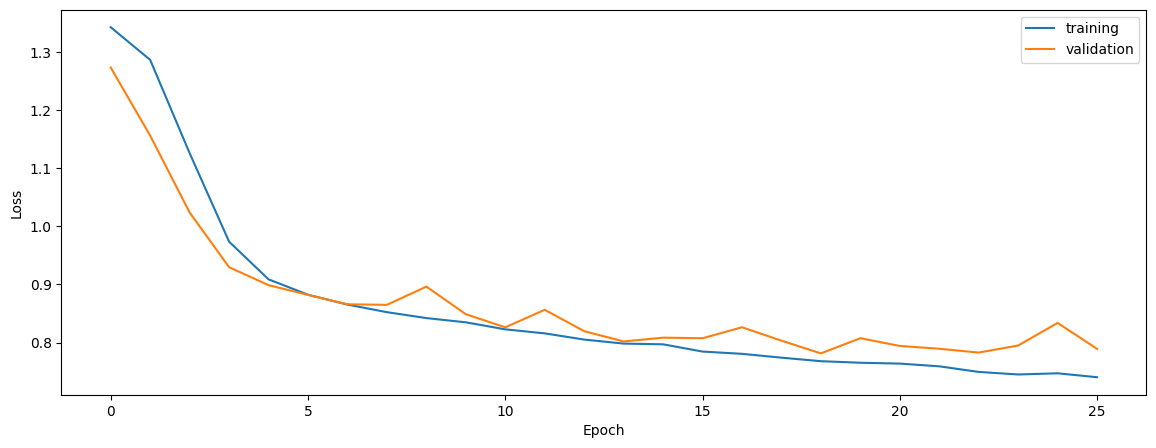

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6940774823668321
0.6980582332490518
0.7010860771782218


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

normalized
0.6940774823668321
0.6980582332490518
0.7010860771782218


In [9]:
print('native')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6902403655206175
0.7044008124576845
0.6994453240038528


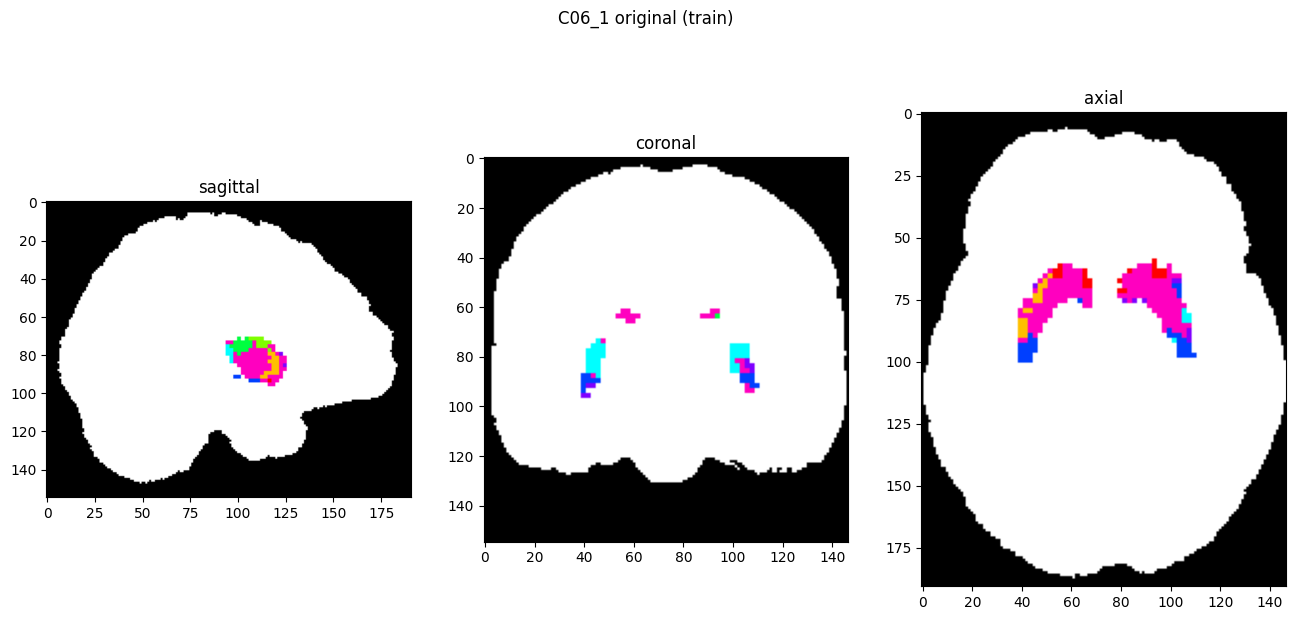

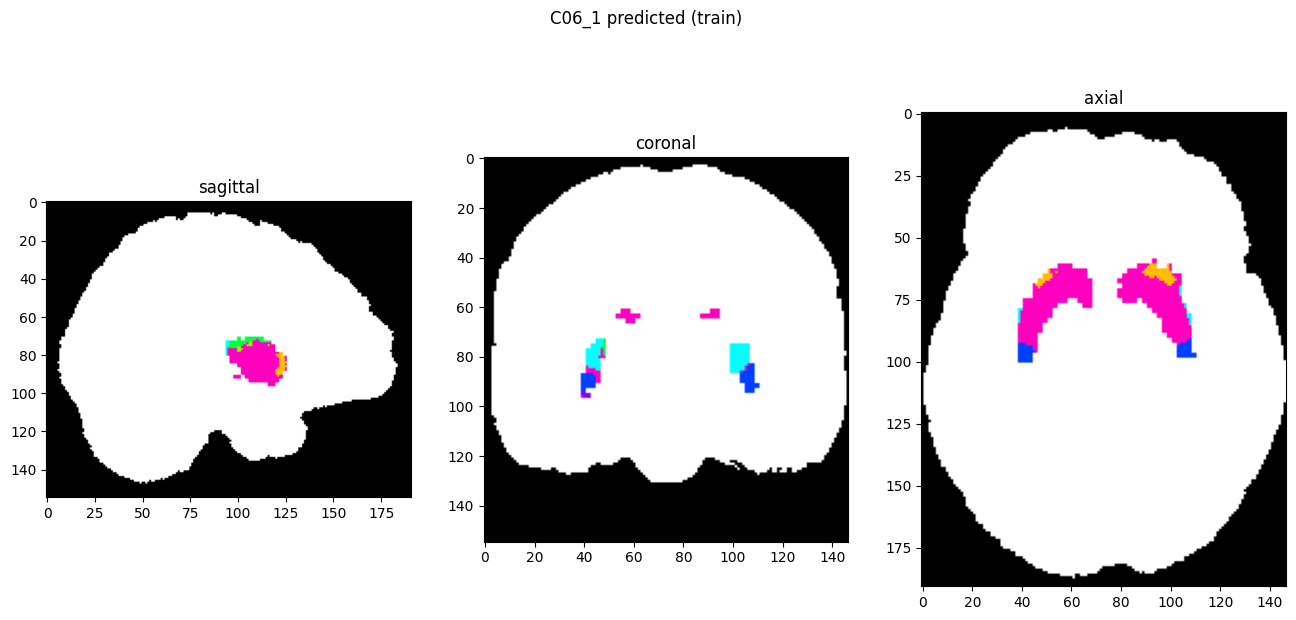

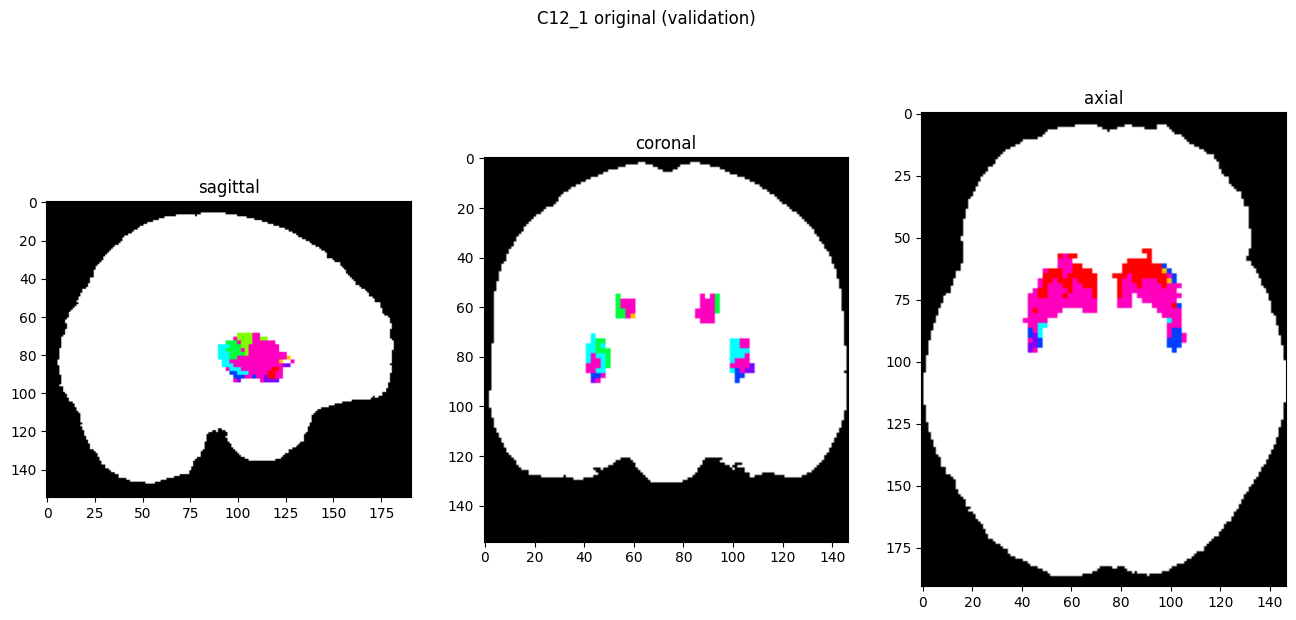

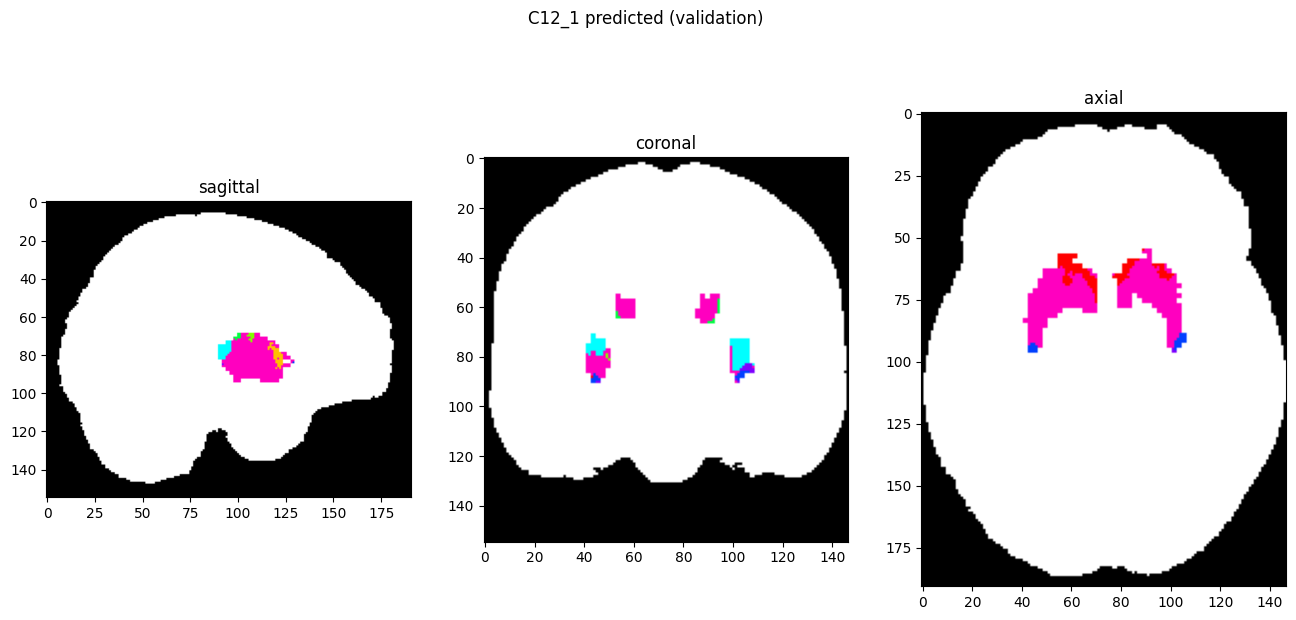

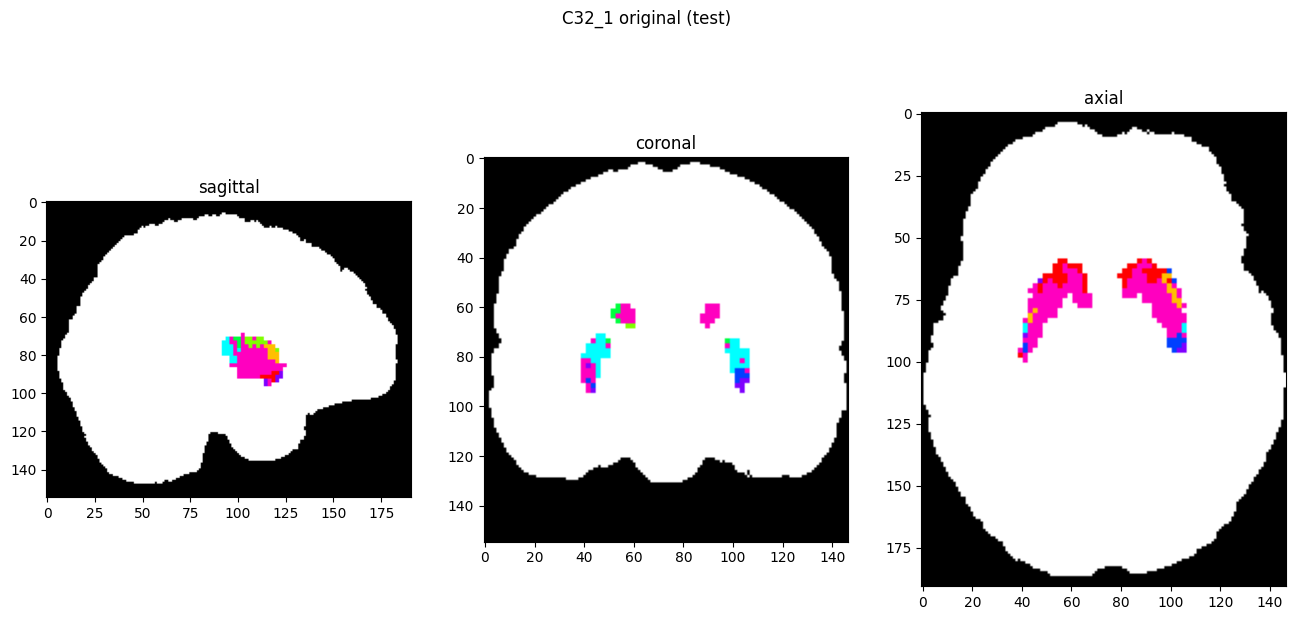

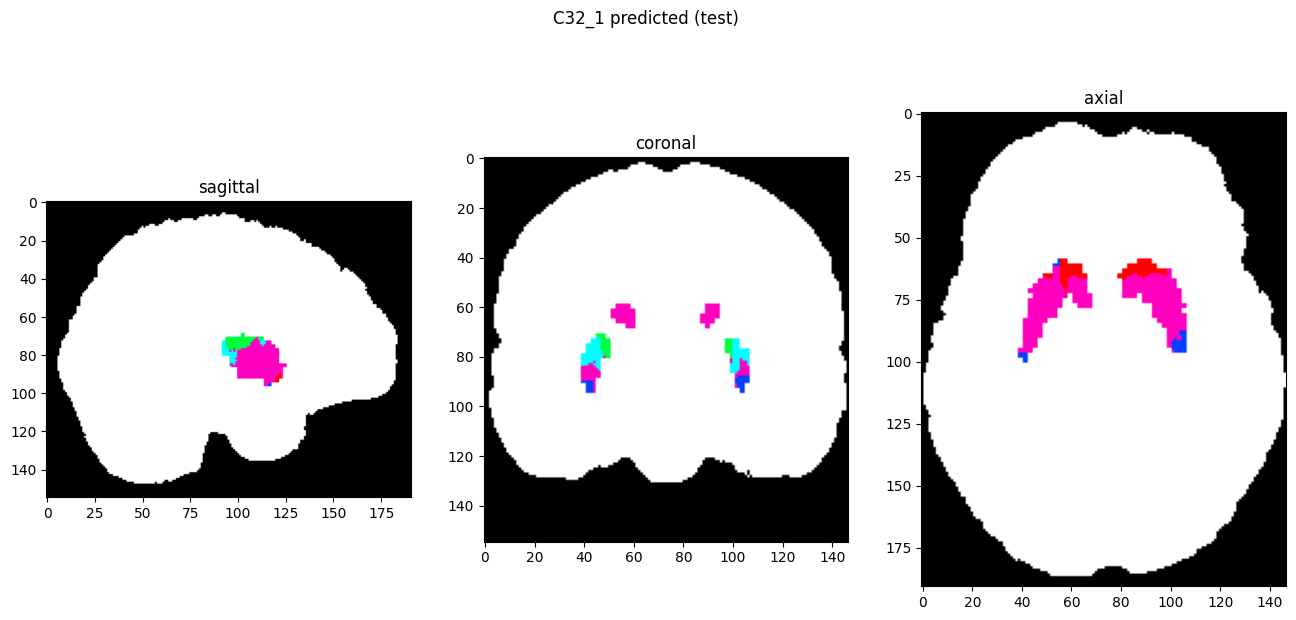

In [10]:
showResults(model, gen, threshold=0)